# **EDA**

## 데이터 및 라이브러리 로드

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['axes.unicode_minus'] = False
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate, KFold, StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

In [39]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

## 데이터 확인

In [16]:
train.head()

ID      대출금액        대출기간       근로기간    주택소유상태       연간소득  \
0  TRAIN_00000  12480000   36 months    6 years      RENT   72000000   
1  TRAIN_00001  14400000   60 months  10+ years  MORTGAGE  130800000   
2  TRAIN_00002  12000000   36 months    5 years  MORTGAGE   96000000   
3  TRAIN_00003  14400000   36 months    8 years  MORTGAGE  132000000   
4  TRAIN_00004  18000000   60 months    Unknown      RENT   71736000   

   부채_대비_소득_비율  총계좌수   대출목적  최근_2년간_연체_횟수   총상환원금     총상환이자  총연체금액  연체계좌수 대출등급  
0        18.90    15  부채 통합             0       0       0.0    0.0    0.0    C  
1        22.33    21  주택 개선             0  373572  234060.0    0.0    0.0    B  
2         8.60    14  부채 통합             0  928644  151944.0    0.0    0.0    A  
3        15.09    15  부채 통합             0  325824  153108.0    0.0    0.0    C  
4        25.39    19  주요 구매             0  228540  148956.0    0.0    0.0    B

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96294 entries, 0 to 96293
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            96294 non-null  object 
 1   대출금액          96294 non-null  int64  
 2   대출기간          96294 non-null  object 
 3   근로기간          96294 non-null  object 
 4   주택소유상태        96294 non-null  object 
 5   연간소득          96294 non-null  int64  
 6   부채_대비_소득_비율   96294 non-null  float64
 7   총계좌수          96294 non-null  int64  
 8   대출목적          96294 non-null  object 
 9   최근_2년간_연체_횟수  96294 non-null  int64  
 10  총상환원금         96294 non-null  int64  
 11  총상환이자         96294 non-null  float64
 12  총연체금액         96294 non-null  float64
 13  연체계좌수         96294 non-null  float64
 14  대출등급          96294 non-null  object 
dtypes: float64(4), int64(5), object(6)
memory usage: 11.0+ MB


> 결측치가 없는 것으로 보이나, 결측치가 0이나 다른 텍스트 등으로 대체되었을 경우가 있어 추후 고려할 필요가 있습니다.

### 자료형 확인 및 처리

In [40]:
cols = train.columns
numcols = train._get_numeric_data().columns
target = '대출등급'
catcols = list(set(cols)-set(numcols))
catcols.remove(target)
display(numcols, catcols)

Index(['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자',
       '총연체금액', '연체계좌수'],
      dtype='object')

['대출기간', '근로기간', '대출목적', 'ID', '주택소유상태']

### `ID` 칼럼 처리

In [41]:
len(train['ID'].unique()) == len(train)

True

> ID 칼럼은 유일성이 확인되고, 의미상으로도 key의 역할을 합니다.  
데이터로서 사용하기에는 무리가 있어보이며, 인덱스로 활용하거나 제거합니다.

In [42]:
# ID 칼럼 제거
train = train.drop('ID', axis = 1)
test = test.drop('ID', axis = 1)
catcols.remove('ID')

### 데이터중복 확인 및 처리

In [6]:
display([train[column].unique() for column in catcols])

[array(['부채 통합', '주택 개선', '주요 구매', '휴가', '의료', '자동차', '신용 카드', '소규모 사업',
        '기타', '이사', '주택', '재생 에너지'], dtype=object),
 array(['6 years', '10+ years', '5 years', '8 years', 'Unknown', '9 years',
        '2 years', '1 year', '3 years', '7 years', '4 years', '< 1 year',
        '10+years', '<1 year', '3', '1 years'], dtype=object),
 array(['RENT', 'MORTGAGE', 'OWN', 'ANY'], dtype=object),
 array([' 36 months', ' 60 months'], dtype=object)]

In [43]:
# 의미가 겹치는 범주 처리
train['근로기간'].replace({'3':'3 years', '<1 year':'< 1 year', '1 years':'1 year', '10+years':'10+ years'}, inplace=True)

In [44]:
# 데이터 중복 확인
print(train.duplicated(keep='first').sum())

0


In [45]:
# 테스트셋에도 적용
test['근로기간'].replace({'3':'3 years', '<1 year':'< 1 year', '1 years':'1 year', '10+years':'10+ years'}, inplace=True)

## 타겟(`대출등급`) 분포

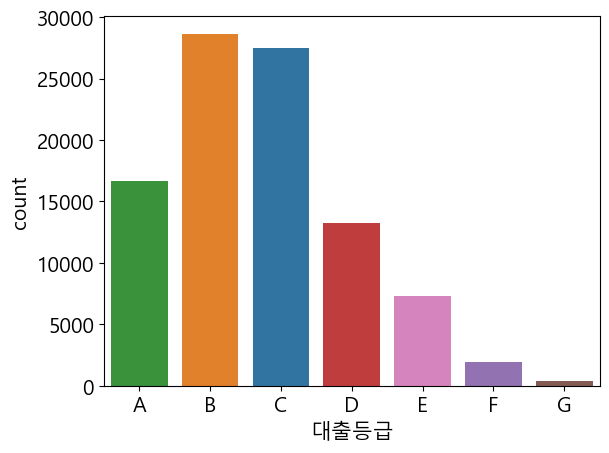

In [22]:
order_grade = ['A','B','C','D','E','F','G']
sns.countplot(x=target, data = train, hue = target, order=order_grade)
plt.show()

> 데이터가 불균형해 오버샘플링도 시도해볼 수 있으나, 시도 후 학습결과가 좋지 않아 결국하지는 않았습니다.

## 실수형 데이터 시각화

### violin plot

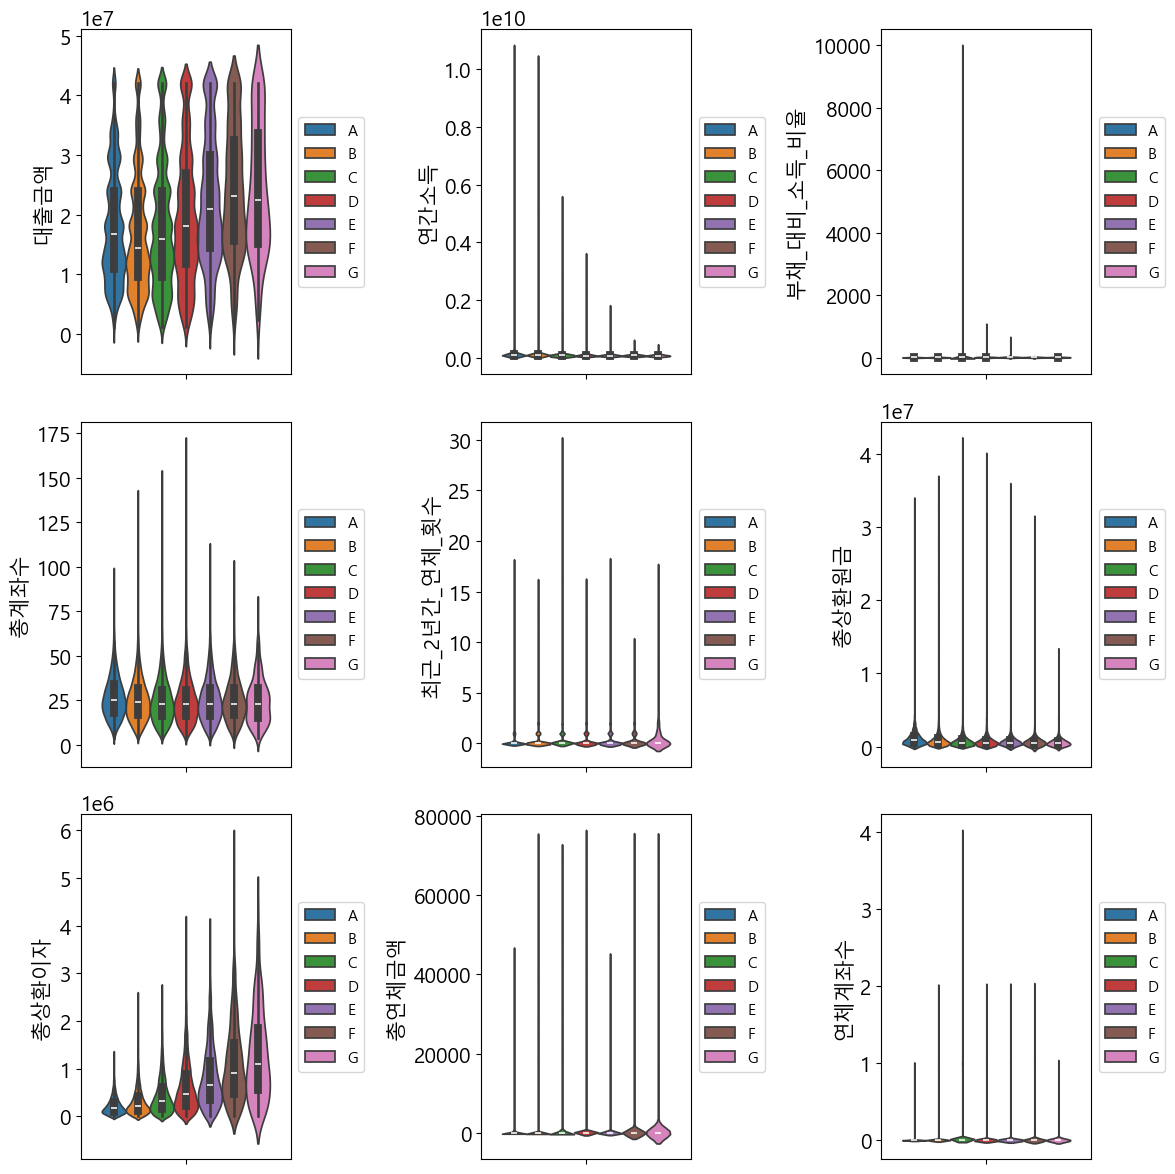

In [26]:
plt.figure(figsize=(12,12))
for idx, feature in enumerate(numcols):
    plt.subplot(3,3,idx+1)
    sns.violinplot(y=numcols[idx], hue = target, data = train, hue_order= order_grade)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=11)
plt.tight_layout()
plt.show()

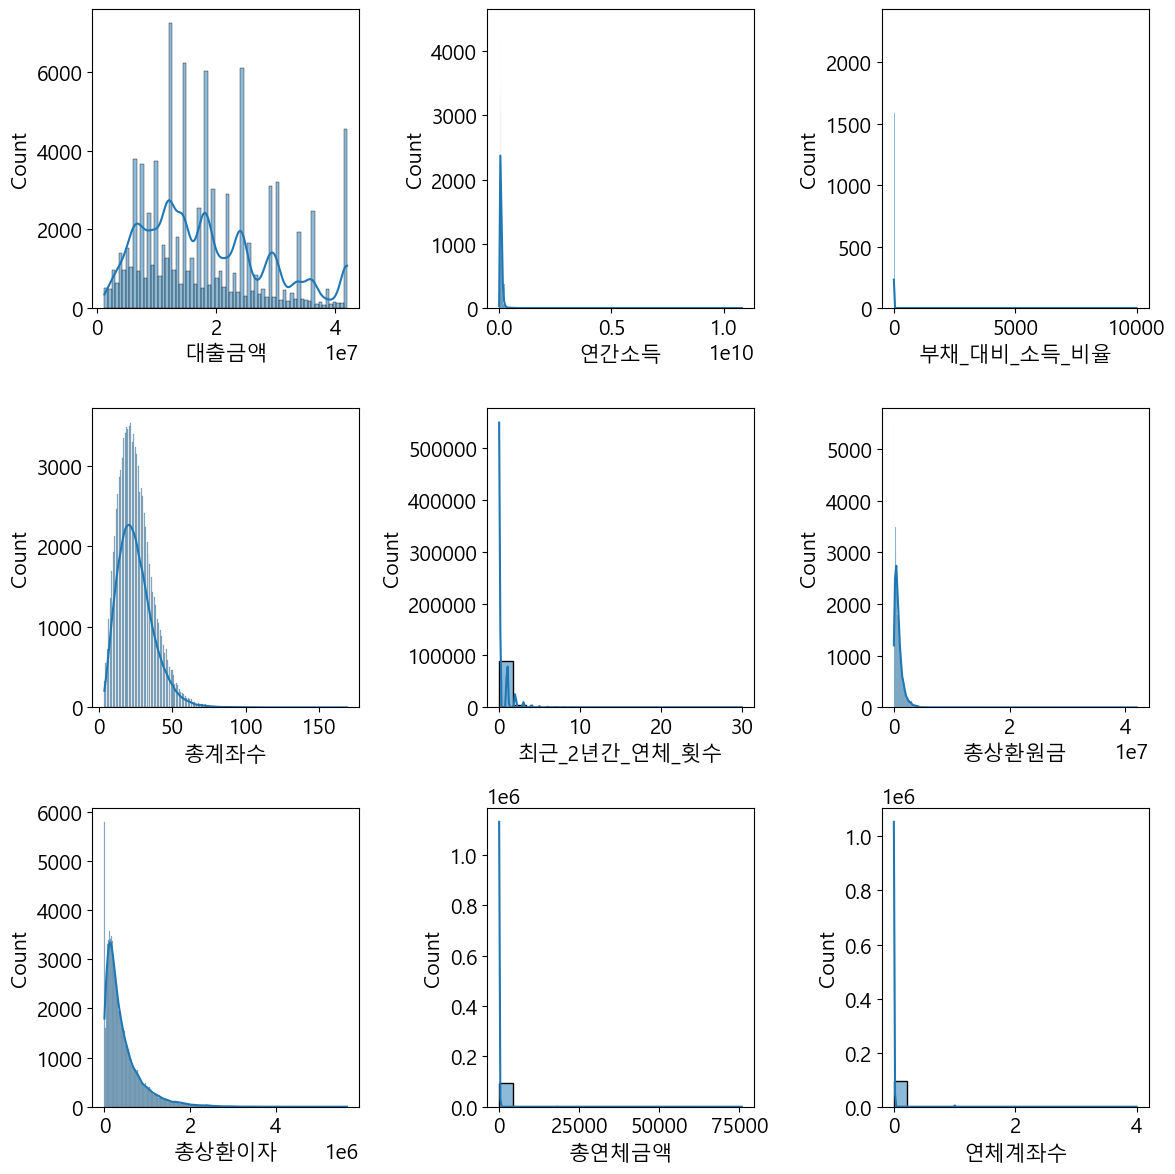

In [27]:
plt.figure(figsize=(12,12))
for idx, feature in enumerate(numcols):
    plt.subplot(3,3,idx+1)
    sns.histplot(x=numcols[idx], data = train, kde=True)
plt.tight_layout()
plt.show()

> 이상치가 분포의 확인을 어렵게 하고 있습니다.

## 범주형 데이터 시각화

### countplot

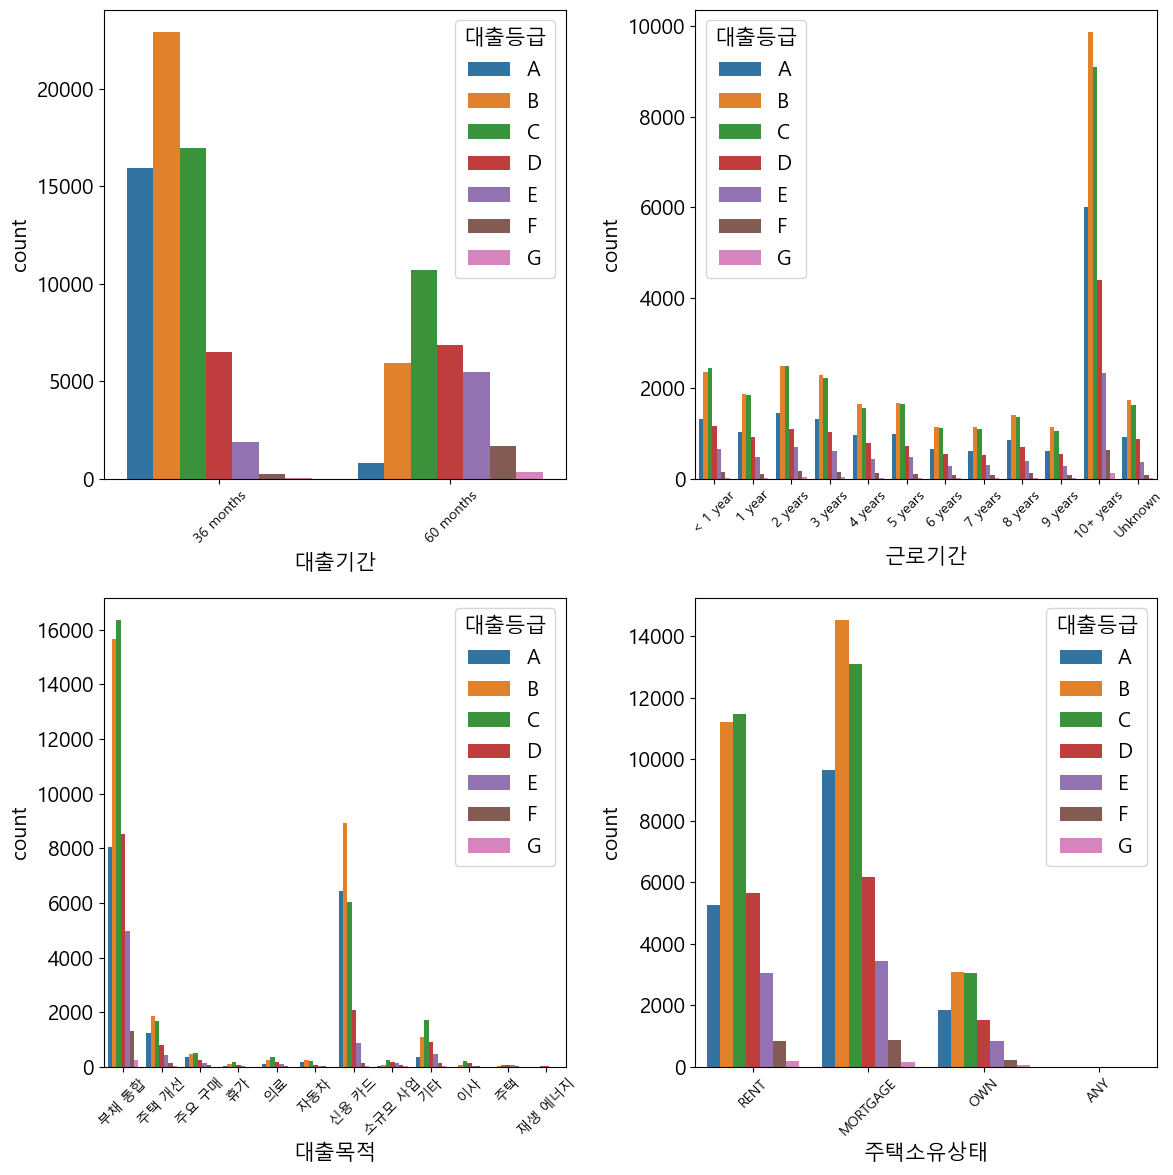

In [57]:
order_years = ['< 1 year','1 year', '2 years', '3 years', '4 years', '5 years', '6 years', 
               '7 years', '8 years', '9 years', '10+ years', 'Unknown']

plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
sns.countplot(x =catcols[0], hue= target, data =train, hue_order= order_grade)
plt.gca().set_xticklabels(plt.gca().get_xticklabels(),fontsize=10, rotation = 45)

plt.subplot(2,2,2)
sns.countplot(x =catcols[1], hue= target, data =train,order = order_years,hue_order= order_grade)
plt.gca().set_xticklabels(plt.gca().get_xticklabels(),fontsize=10, rotation = 45)

plt.subplot(2,2,3)
sns.countplot(x =catcols[2], hue= target, data =train, hue_order= order_grade)
plt.gca().set_xticklabels(plt.gca().get_xticklabels(),fontsize=10, rotation = 45)

plt.subplot(2,2,4)
sns.countplot(x =catcols[3], hue= target, data =train, hue_order= order_grade)
plt.gca().set_xticklabels(plt.gca().get_xticklabels(),fontsize=10, rotation = 45)

plt.tight_layout()
plt.show()

### 각 범주별 상대도수를 나타내는 heat map (피쳐 vs 타겟)

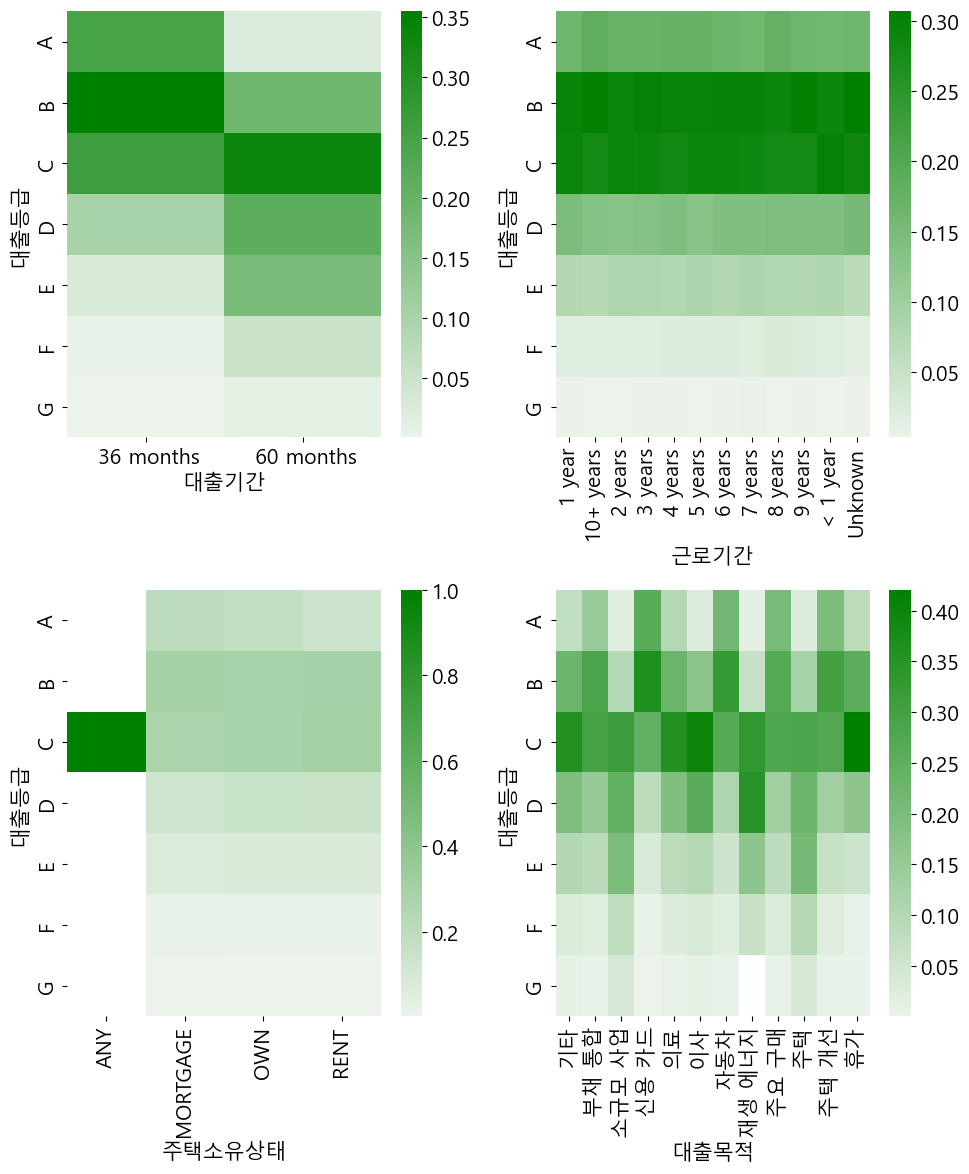

In [29]:
plt.figure(figsize=(10,12))
for idx, feature in enumerate(catcols):
    plt.subplot(2,2,idx+1)
    pivot = train.pivot_table(
    index=feature, columns = target, aggfunc="size")
    pivot['sum'] = pivot.sum(axis=1)
    for column in pivot.columns:
        pivot[column] = pivot[column] / pivot['sum']
    pivot = pivot.drop('sum',axis=1).T
    sns.heatmap(pivot, cmap=sns.light_palette('Green',as_cmap=True), annot=False)
plt.tight_layout()
plt.show()

> `대출기간`과 `대출목적`은 그 범주에 따라 대출등급의 분포가 다른 것이 확인됩니다.  
> 반면, `주택소유상태`와 `근로기간`은 범주에 따라 대출등급의 분포가 매우 유사한 것이 관찰됩니다.  
> 또한, `대출목적`은 범주가 상대적으로 많고, 데이터가 적은 범주도 다수 존재합니다. 학습데이터에 그대로 사용 시 과적합의 위험도 경계할 필요가 있습니다.

## 이상치

### z-score 기반 이상치 탐지

> 3이상의 z-score에 대해서 데이터 손실량 체크를 해봅니다.  
앞선 히스토그램에서 대다수가 같은 값을 가진 `총연체금액`과 `연체계좌수`의 z-score는 고려하지 않습니다.

In [47]:
from scipy import stats
z_scores = stats.zscore(train[numcols].drop(['총연체금액','연체계좌수'], axis = 1))

outlier_ratio = {}
threshold_to_try = {}
for threshold in np.linspace(3,10,71):
    outliers_z = train.drop(['총연체금액','연체계좌수'],axis=1)[(z_scores > threshold).any(axis=1)]
    train_drop_outlier = train.copy()[(z_scores < threshold).all(axis=1)]

    outlier_ratio[threshold] = round(len(outliers_z)/len(train) * 100,4)
    threshold_to_try[threshold] = train_drop_outlier
outlier_ratio

{3.0: 5.6099,
 3.1: 5.2319,
 3.2: 4.8705,
 3.3: 4.4219,
 3.4: 4.1498,
 3.5: 3.9847,
 3.6: 3.7967,
 3.7: 3.6108,
 3.8: 3.4478,
 3.9: 3.265,
 4.0: 2.4404,
 4.1: 2.3449,
 4.2: 2.2203,
 4.3: 2.1216,
 4.4: 2.0385,
 4.5: 1.9129,
 4.6: 1.8402,
 4.7: 1.7696,
 4.8: 1.7125,
 4.9: 1.6543,
 5.0: 1.5972,
 5.1: 1.1891,
 5.2: 1.1382,
 5.300000000000001: 1.1143,
 5.4: 1.0759,
 5.5: 1.0458,
 5.6: 1.0229,
 5.7: 0.9783,
 5.800000000000001: 0.9585,
 5.9: 0.9357,
 6.0: 0.9201,
 6.1: 0.9035,
 6.2: 0.7072,
 6.300000000000001: 0.6802,
 6.4: 0.6667,
 6.5: 0.6584,
 6.6: 0.647,
 6.7: 0.6366,
 6.800000000000001: 0.6241,
 6.9: 0.6086,
 7.0: 0.6034,
 7.1000000000000005: 0.5961,
 7.2: 0.5867,
 7.3: 0.4922,
 7.4: 0.4912,
 7.5: 0.4787,
 7.6000000000000005: 0.4756,
 7.7: 0.4704,
 7.800000000000001: 0.4673,
 7.9: 0.4642,
 8.0: 0.46,
 8.100000000000001: 0.4507,
 8.2: 0.4486,
 8.3: 0.4434,
 8.4: 0.3718,
 8.5: 0.3666,
 8.600000000000001: 0.3645,
 8.7: 0.3572,
 8.8: 0.3541,
 8.9: 0.35,
 9.0: 0.3469,
 9.100000000000001: 0.34

**1. 시도1: z-score기준을 10으로 높게 잡아보기**

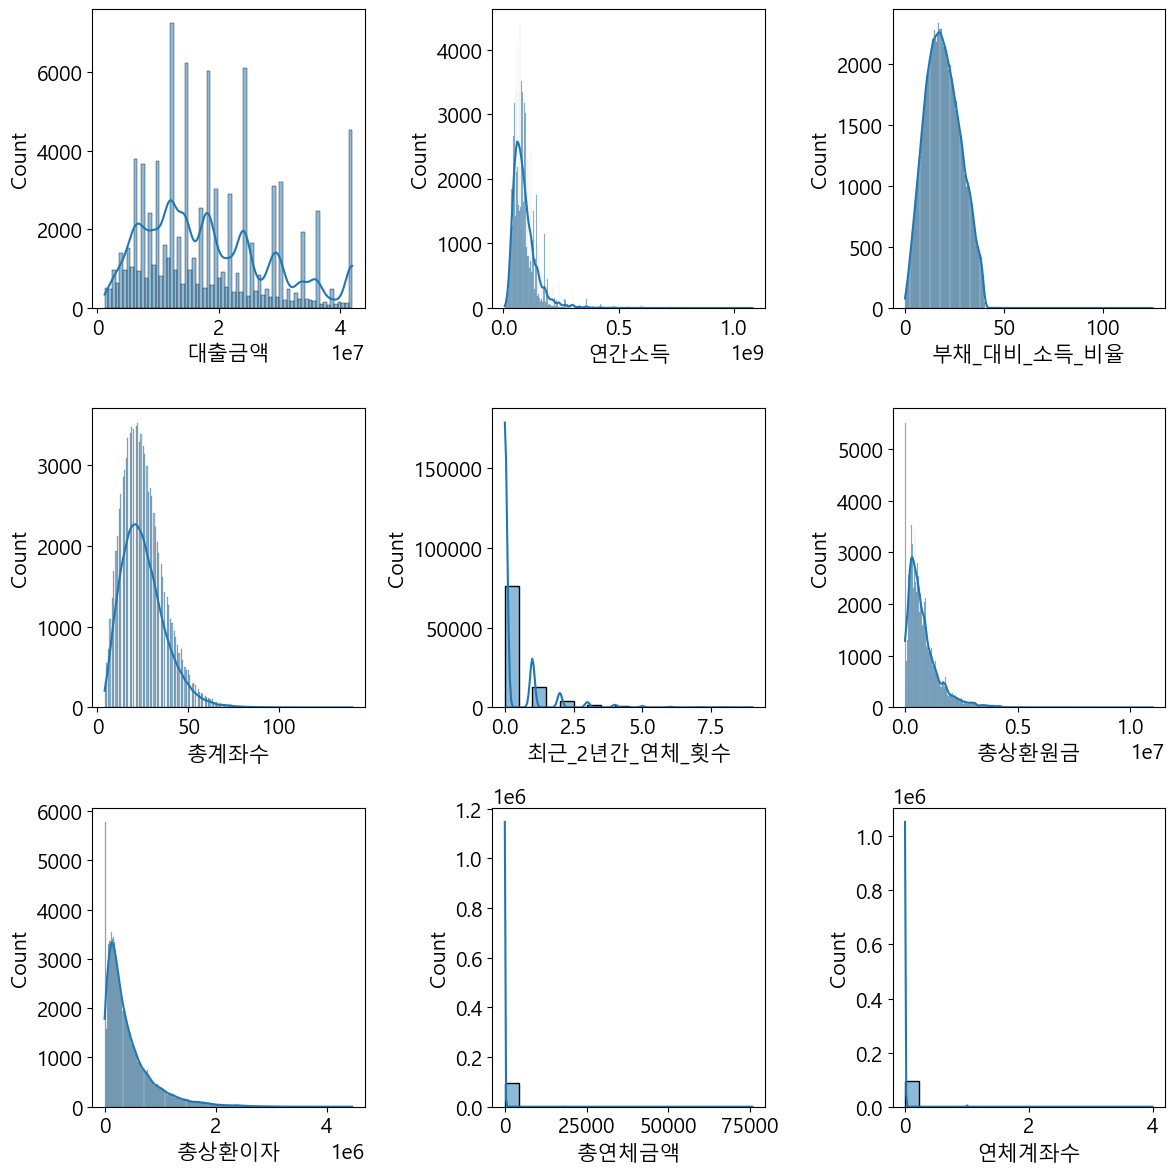

In [31]:
train_del_outlier_try1 = threshold_to_try[10.0]
plt.figure(figsize=(12,12))
for idx in range(len(numcols)):
    plt.subplot(3,3,idx+1)
    sns.histplot(x=numcols[idx], data = train_del_outlier_try1, kde=True)
plt.tight_layout()
plt.show()

>`부채_대비_소득_`과 단독으로 사용하지 않을 `총연체금액` 및 `연체계좌수`를 제외하고는 데이터 분포의 복잡성이 거의 없고 경향이 뚜렷합니다.

**2. 시도2: z-score기준을 3으로 낮게 잡아보기**

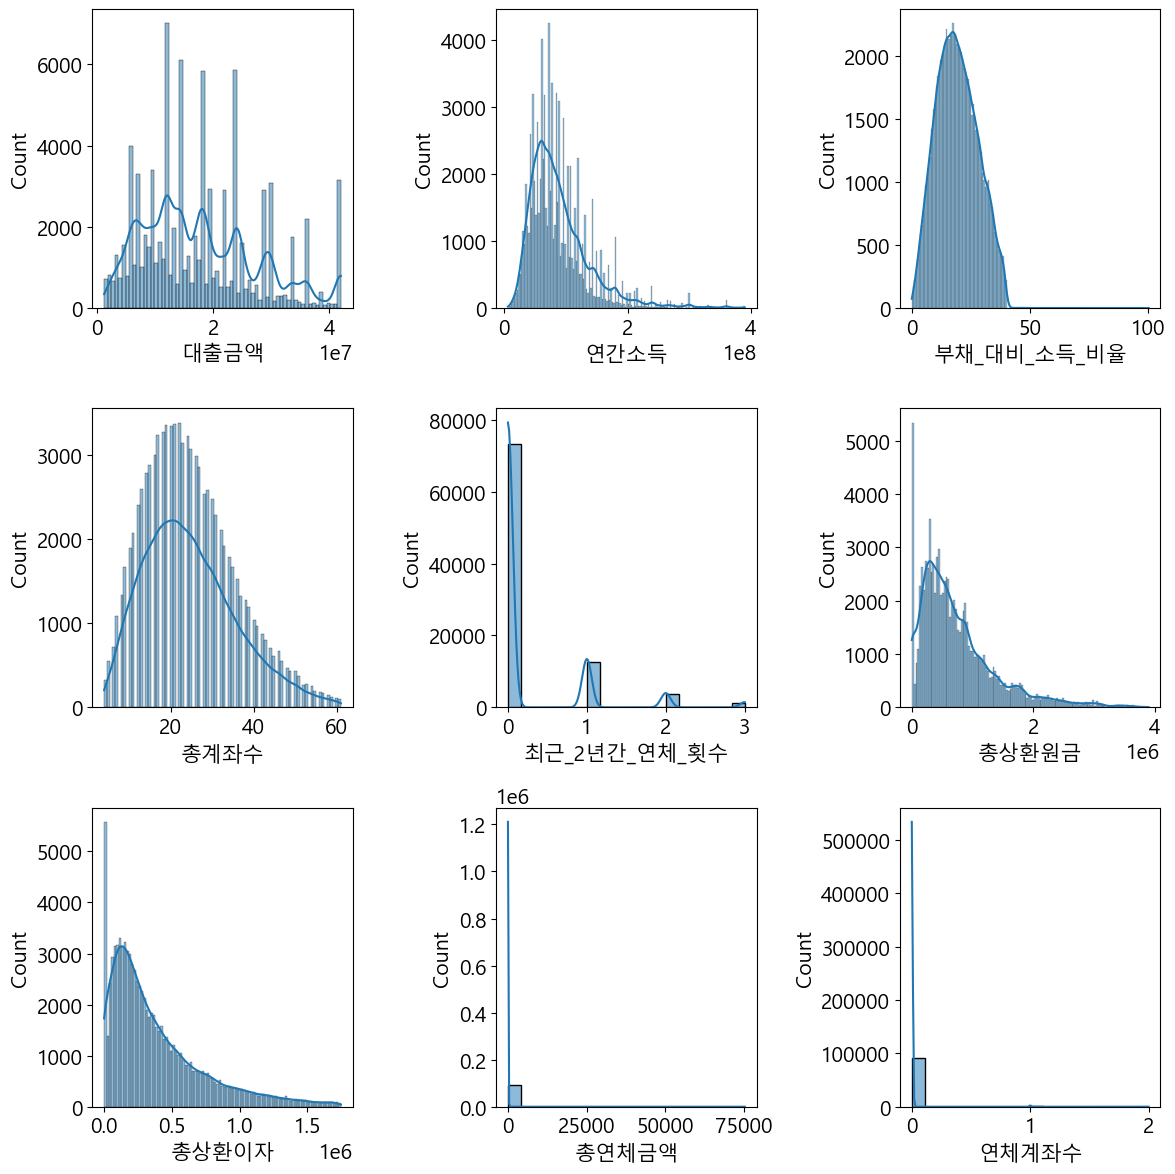

In [32]:
train_del_outlier_try2 = threshold_to_try[3.0]
plt.figure(figsize=(12,12))
for idx in range(len(numcols)):
    plt.subplot(3,3,idx+1)
    sns.histplot(x=numcols[idx], data = train_del_outlier_try2, kde=True)
plt.tight_layout()
plt.show()

> 기준이 10일 때에 비해, 다른 분포의 꼬리 부분이 상당 수 손실된 것이 보입니다.

**3. 시도3: z-score기준을 7로 앞선 시도의 중간 지점으로 잡아보기**

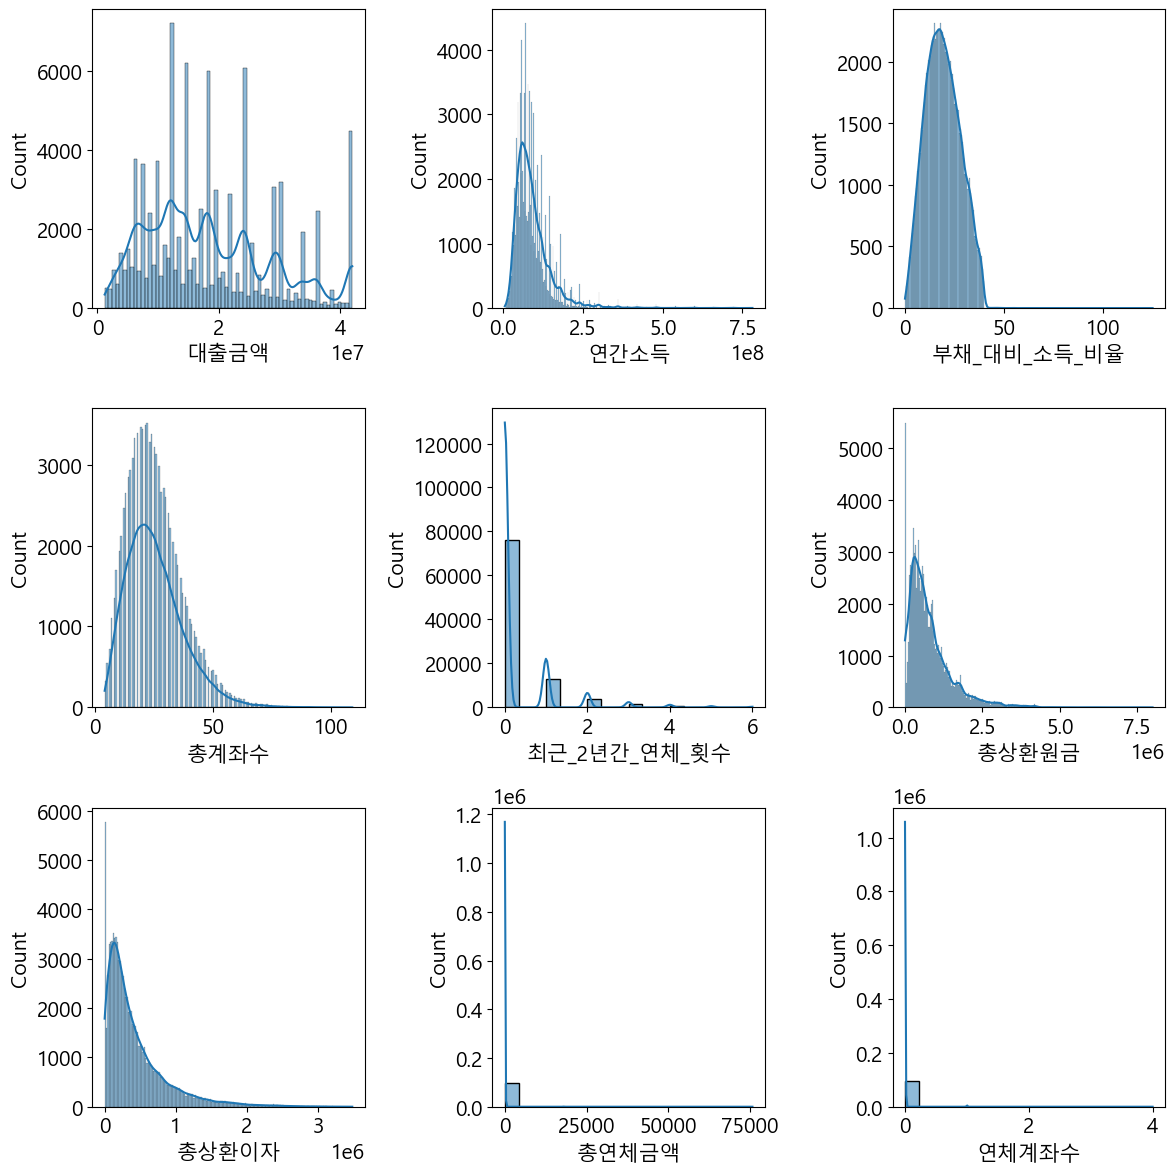

In [33]:
train_del_outlier_try3 = threshold_to_try[7.0]
plt.figure(figsize=(12,12))
for idx in range(len(numcols)):
    plt.subplot(3,3,idx+1)
    sns.histplot(x=numcols[idx], data = train_del_outlier_try3, kde=True)
plt.tight_layout()
plt.show()

In [34]:
outlier_ratio[7.0]

0.6034

> 3에 비해 꼬리부분의 데이터 손실을 줄이고, 마냥 극단적인 값만을 갖지 않도록 적당한 기준이 될 수 있을 것이라 판단했습니다.  
> 이 때, 정보손실량은 전체 데이터의 0.6%로 극소수인 것을 알 수 있습니다.   
> 주목해볼만한 점은 z-score 기반 이상치 처리 후에도, `부채_대비_소득_비율`은 약 45이상의 값에서 데이터 전반 경향성에서 벗어난 데이터들이 포착됩니다.

**4. 45이상의 `부채_대비_소득_비율`값을 가진 데이터 확인**

In [35]:
train_del_outlier_try3[train_del_outlier_try3['부채_대비_소득_비율']>45].shape[0]

26

> 26개로 전체에 비해 극소수의 데이터이므로, 과감하게 이상치 처리하기로 결정합니다.

### 이상치 처리

In [48]:

filt = ((z_scores > 7.0).any(axis=1)) | (train['부채_대비_소득_비율']>45)
outliers = train.copy()[filt]
outliers
train_prep = train.copy()[~filt]

> 탐지된 이상치를 제거하는 것으로 처리 방법을 결정합니다.

## 이상치 처리 후, 실수형 데이터 시각화

### violin plot

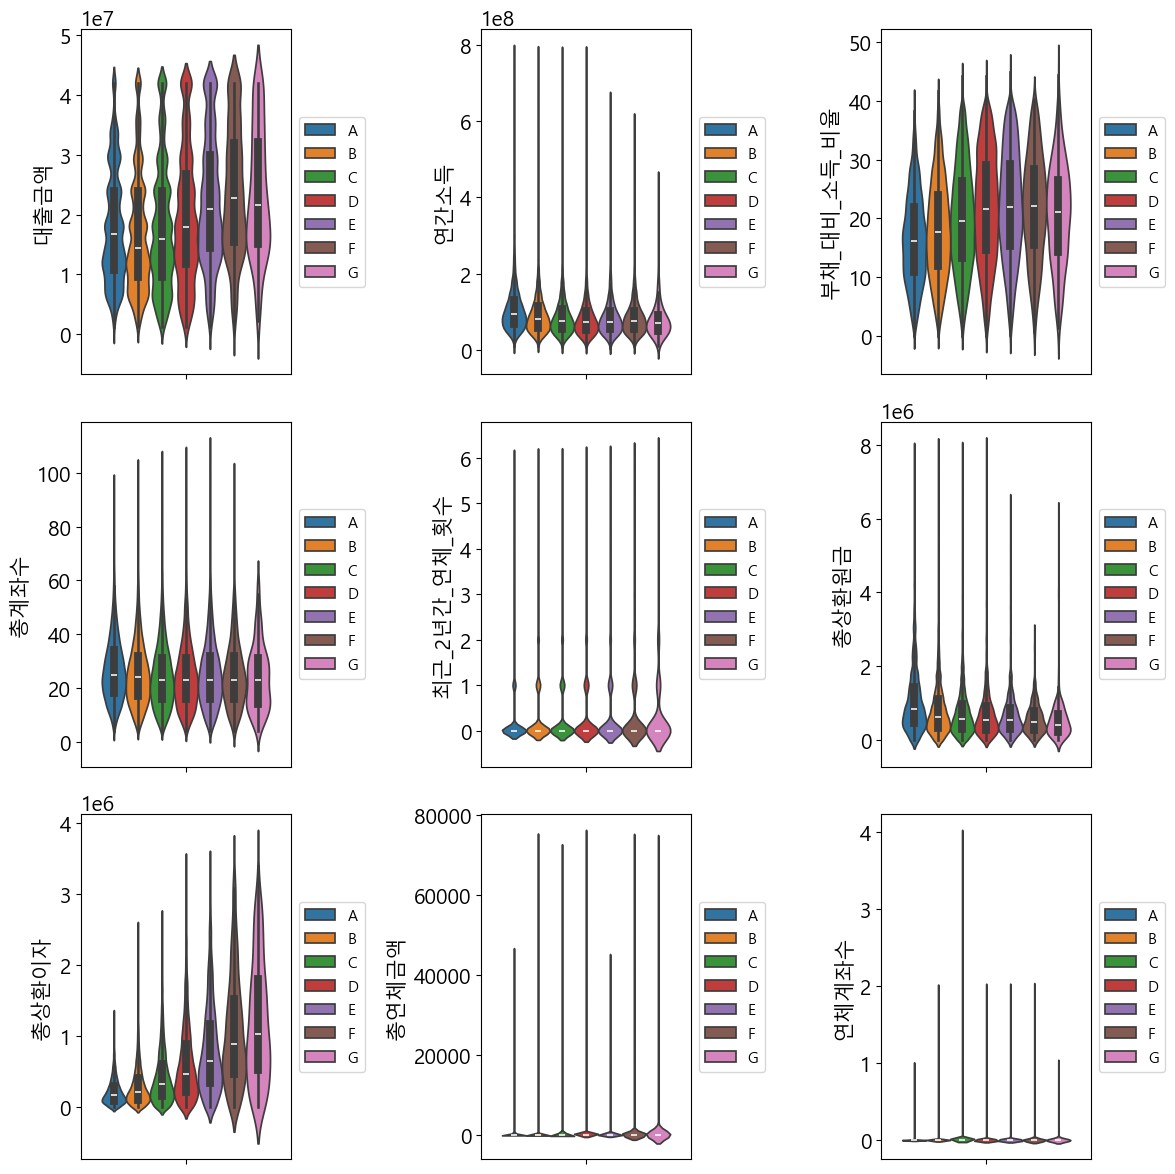

In [37]:
plt.figure(figsize=(12,12))
for idx, feature in enumerate(numcols):
    plt.subplot(3,3,idx+1)
    sns.violinplot(y=numcols[idx], hue = target, data = train_prep, hue_order= order_grade)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=11)
plt.tight_layout()
plt.show()

### histogram

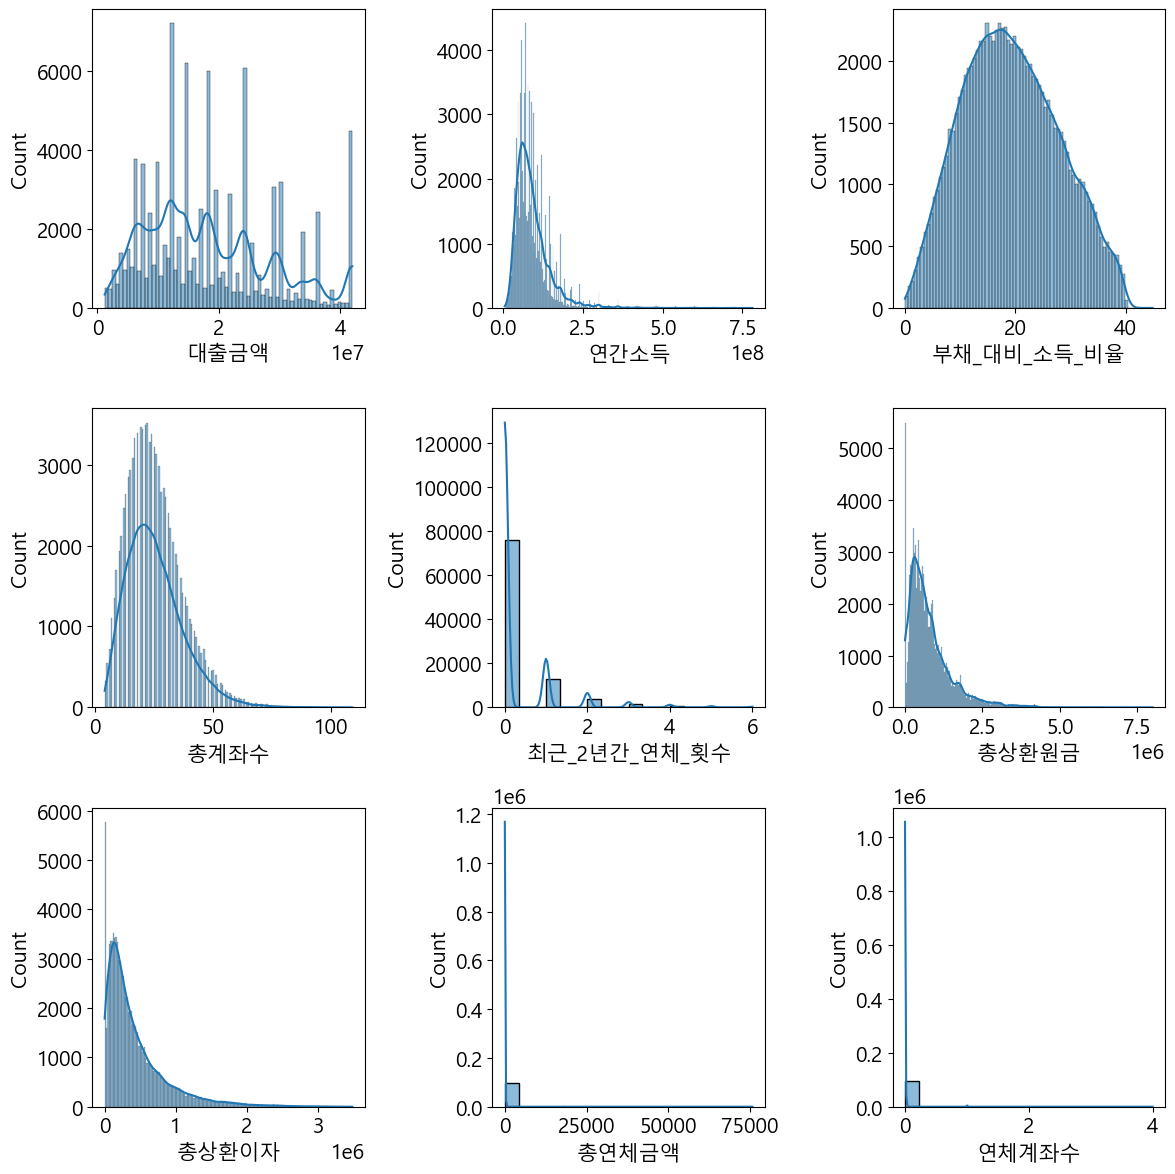

In [38]:
plt.figure(figsize=(12,12))
for idx, feature in enumerate(numcols):
    plt.subplot(3,3,idx+1)
    sns.histplot(x=numcols[idx], data = train_prep, kde=True)
plt.tight_layout()
plt.show()

> (1) 이상치 처리 후에도 `총연체금액`, `연체계좌수`는 데이터간의 유의미한 차이가 없어, 단독으로는 타겟에 대한 학습이 불가능할 것으로 보입니다.  
>   
> (2) 한가지 확인가능한 것은 `총상환이자`, `총상환원금`에서 값이 0인 데이터가 상당 수 존재하는 것을 관찰할 수 있습니다. 이 피쳐의 의미와 0 이라는 특수성을 생각해보면, 0인지 아닌지를 기준으로 데이터 그룹을 나누는 등의 시도가 가능해 보입니다.  
>
> (3) 또한, `총상환원금`과 `총상환이자는`, `연간소득`은 왜도를 띤 정규분포형태(chi-square)를 띠는데, 이는 로그변환을 통해 데이터를 정규분포 형태로 만들 수도 있습니다.

### pairplot

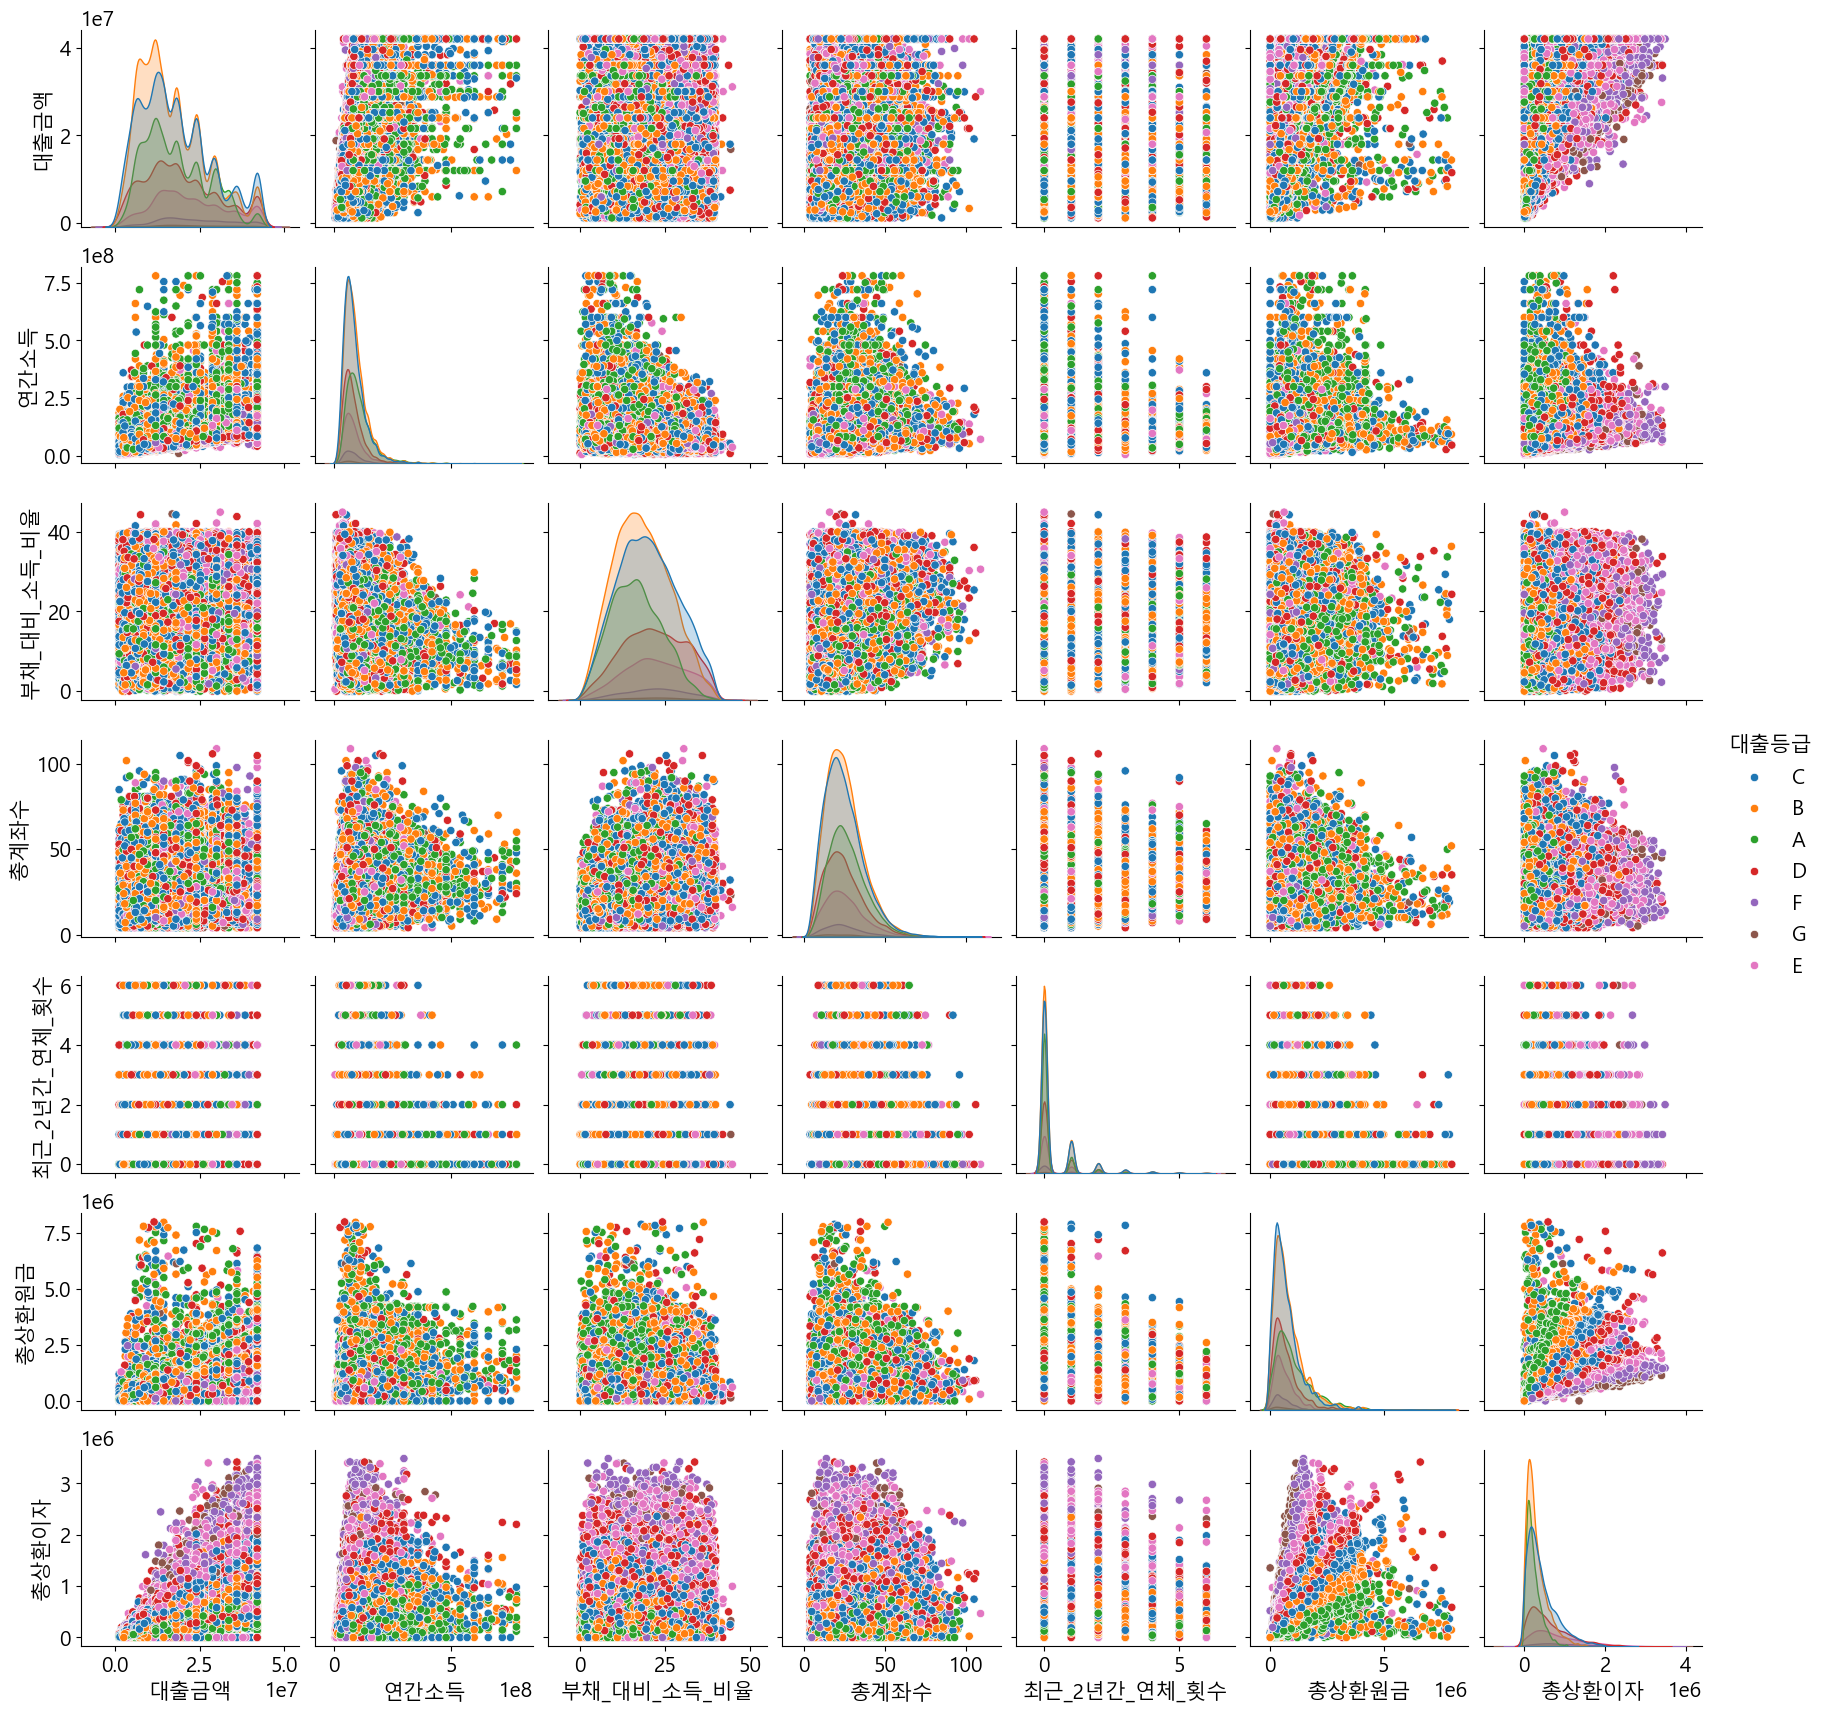

In [49]:
sns.pairplot(train_prep.drop(['총연체금액','연체계좌수'], axis=1), hue = target)

> `총상환이자` 혹은 `총상환원금`과 관련된 플롯에서 경향성이 조금씩 보이며,    
> 특히 `총상환이자`와 `총상환원금` 사이에서 명확한 경계가 파악됩니다.  
> 두 피쳐들이 앞으로의 예측에 중요한 역할을 할 것으로 판단되며, 좀 더 면밀히 살펴보겠습니다.  

## `총상환원금`, `총상환이자`

### 값이 0인 그룹 vs 0이 아닌 그룹

> 앞선 히스토그램에서 이 두 피쳐들은 0을 값으로하는 데이터가 상당수 존재했습니다. 따라서 0인 그룹과 아닌 그룹을 나누어, 타겟분포가 어떻게 되는 지 시각화해봅니다.

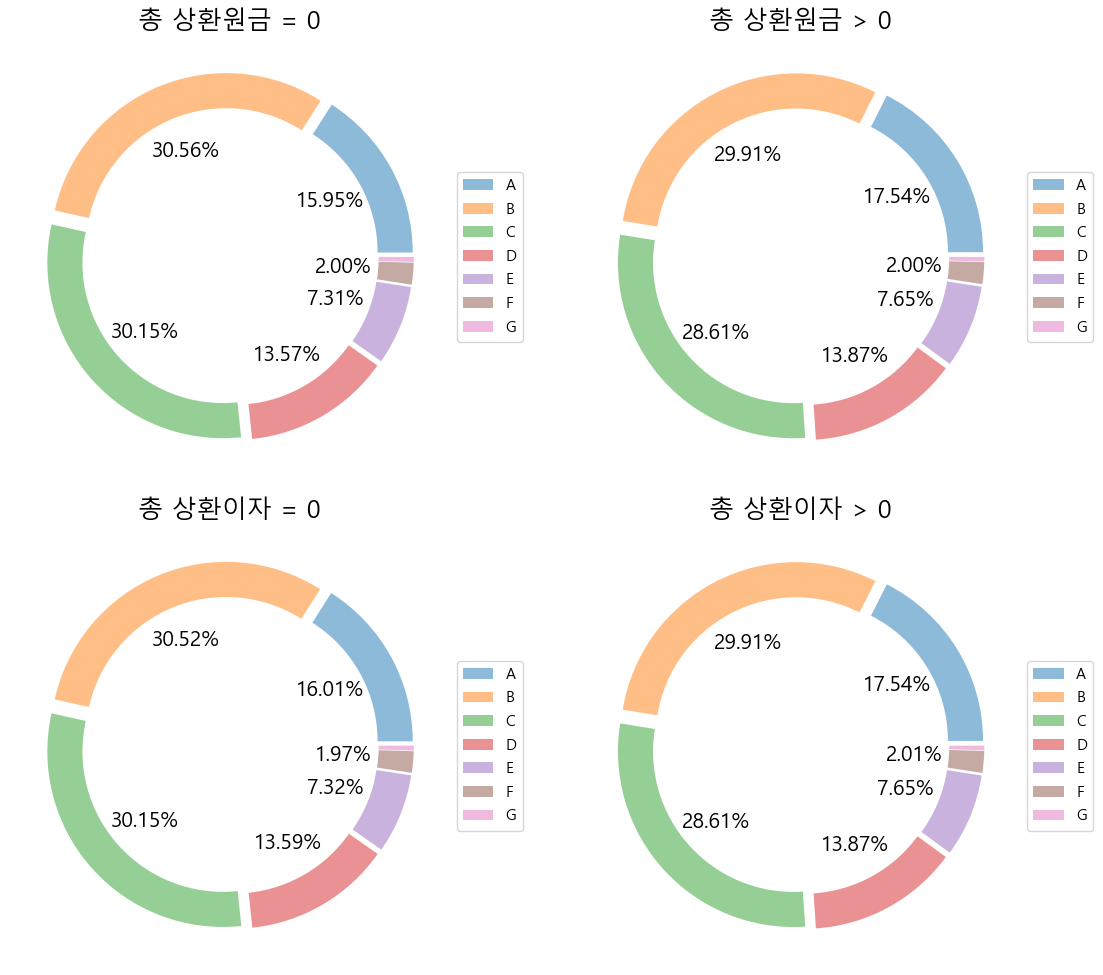

In [40]:
def custom_autopct(pct):
    return('%.2f%%' % pct) if pct >= 1 else ""

plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
data = train_prep[train_prep['총상환원금'] == 0]['대출등급'].value_counts().sort_index()
plt.pie(data.values, explode = [0.05] * 7, autopct = custom_autopct, 
        wedgeprops = {'width':0.2, 'alpha' : 0.5}, pctdistance = 0.6)
plt.gca().set_title('총 상환원금 = 0')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), labels = data.index, fontsize=11)

plt.subplot(2,2,2)
data = train_prep[train_prep['총상환원금'] > 0]['대출등급'].value_counts().sort_index()
plt.pie(data.values, explode = [0.05] * 7, autopct = custom_autopct, 
        wedgeprops = {'width':0.2, 'alpha' : 0.5}, pctdistance = 0.6)
plt.gca().set_title('총 상환원금 > 0')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), labels = data.index, fontsize=11)

plt.subplot(2,2,3)
data = train_prep[train_prep['총상환이자'] == 0]['대출등급'].value_counts().sort_index()
plt.pie(data.values, explode = [0.05] * 7, autopct = custom_autopct, 
        wedgeprops = {'width':0.2, 'alpha' : 0.5}, pctdistance = 0.6)
plt.gca().set_title('총 상환이자 = 0')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), labels = data.index, fontsize=11)

plt.subplot(2,2,4)
data = train_prep[train_prep['총상환이자'] > 0]['대출등급'].value_counts().sort_index()
plt.pie(data.values, explode = [0.05] * 7, autopct = custom_autopct, 
        wedgeprops = {'width':0.2, 'alpha' : 0.5}, pctdistance = 0.6)
plt.gca().set_title('총 상환이자 > 0')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), labels = data.index, fontsize=11)

plt.tight_layout()
plt.show()

In [41]:
num1 = len(train_prep[(train_prep['총상환이자'] == 0) & (train_prep['총상환원금'] != 0)])
num2 = len(train_prep[(train_prep['총상환이자'] != 0) & (train_prep['총상환원금'] == 0)])
num3 = len(train_prep[(train_prep['총상환이자'] == 0) & (train_prep['총상환원금'] == 0)])
num4 = len(train_prep[(train_prep['총상환이자'] == 0) | (train_prep['총상환원금'] == 0)])
print(num1, num2, num3, num4)

35 5 5388 5428


In [42]:
num4/len(train_prep) * 100

5.672661908096189

> 총상환원금만 0이거나 총상환이자만 0인 데이터는 매우 적고, 두 값이 동시에 0인 데이터가 상당수 인것을 알 수 있습니다. 원그래프를 보면, 0인 그룹과 0이 아닌 그룹의 타겟분포차이가 크지 않습니다.  
> 이것이 강력한 판단 근거가 되지는 못하지만, 이 값들은 결측치로 간주해야할 가능성이 높습니다.  
> 추론컨대, 실제로 값이 0인 데이터들도 존재하고 결측인 데이터들도 공존할 것이라 추측됩니다.  
> 참고로, 이 데이터들은 전체 데이터의 약 5.7%를 차지하고 있습니다.

### `총상환원금` vs `총상환이자`

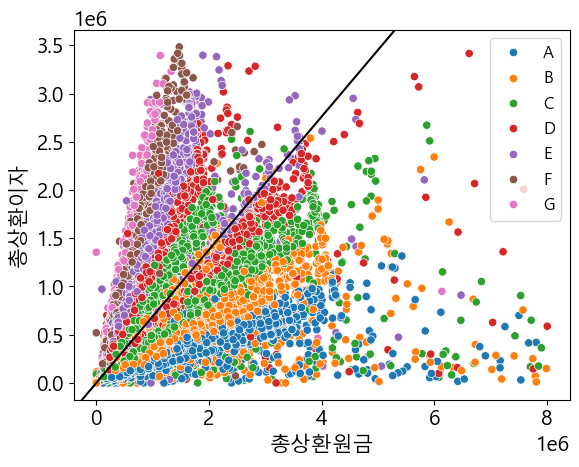

In [43]:
sns.scatterplot(x='총상환원금',y='총상환이자',hue=target,data=train_prep,
                hue_order=order_grade)
plt.axline((0,0),slope=0.69, color='black')
plt.legend(fontsize =12)
plt.show()

> 검은 선을 기준으로 클러스터링이 가능해보입니다.

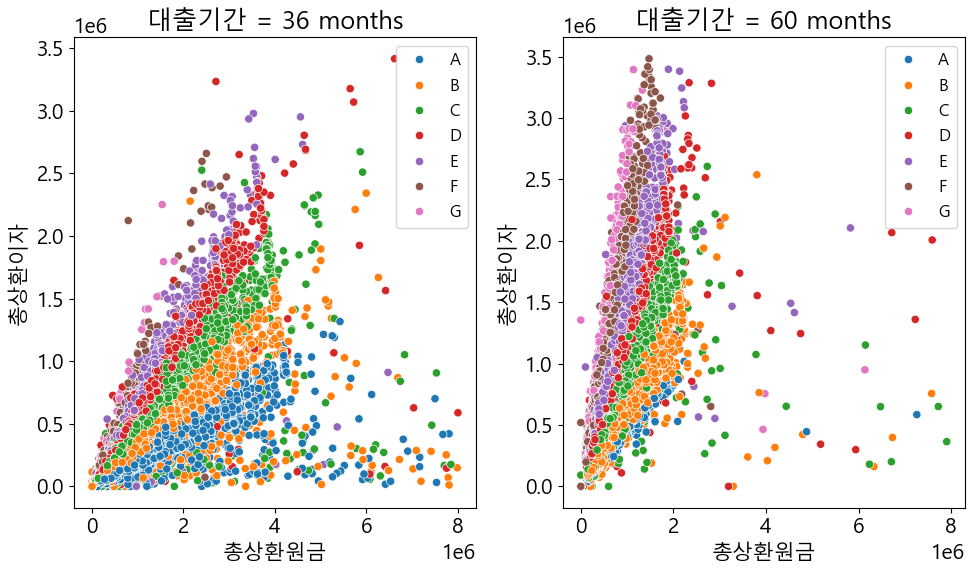

In [44]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
sns.scatterplot(x='총상환원금',y='총상환이자',hue=target,data=train_prep[train_prep['대출기간']==' 36 months'],
                hue_order=order_grade)
plt.gca().set_title('대출기간 = 36 months')
plt.legend(fontsize =12)

plt.subplot(1,2,2)
sns.scatterplot(x='총상환원금',y='총상환이자',hue=target,data=train_prep[train_prep['대출기간']==' 60 months'],
                hue_order=order_grade)
plt.gca().set_title('대출기간 = 60 months')
plt.legend(fontsize =12)

plt.tight_layout()
plt.show()

> 데이터 모양새가 두 구역으로 나눠볼만 하다는 점, `대출기간`데이터가 직관적으로 두 그룹간의 명확한 차이를 보인다는 점에 입각하여 분리해보았습니다.  
> 앞선 직선에 의한 분할보다 더 명쾌한 인사이트를 줍니다.

### 로그변환

> `총상환원금`과 `총상환이자`를 로그변환 시도합니다. 그 근거는 다음과 같습니다.  
> 1. 히스토그램에서 두 데이터가 왜도를 띤 정규분포를 따릅니다.  
> 2. 단위가 $10^6$으로 큰 값을 가지고 있습니다.  
> 3. 산점도 플랏을 보면, 뒤로 갈수록 데이터 포인트간의 간격이 멀어집니다.

In [11]:
train_prep['log원금'] = np.log(train_prep['총상환원금'])
train_prep['log이자'] = np.log(train_prep['총상환이자'])

In [12]:
train_prep['log대출'] = np.log(train_prep['대출금액'])
train_prep['log소득'] = np.log(train_prep['연간소득'])

> 그리고 더불어, 단위가 큰 `대출금액` 데이터와, 왜도가 있는 정규분포형을 띠는 `연간소득`데이터도 로그변환을 시도합니다.

In [13]:
test['log원금'] = np.log(test['총상환원금'])
test['log이자'] = np.log(test['총상환이자'])
test['log대출'] = np.log(test['대출금액'])
test['log소득'] = np.log(test['연간소득'])

### `log원금` vs `log이자`

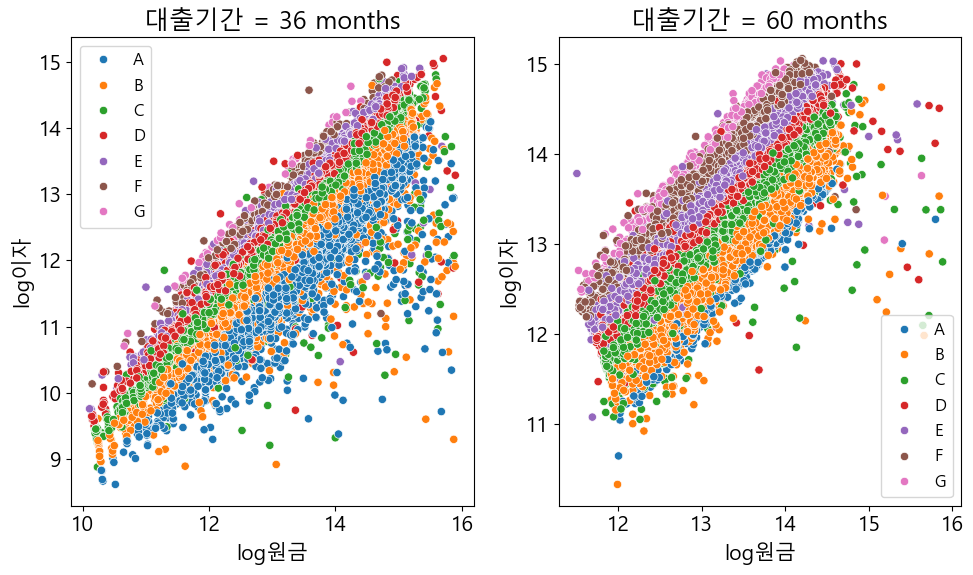

In [48]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
sns.scatterplot(x='log원금',y='log이자',hue=target,data=train_prep[train_prep['대출기간']==' 36 months'],
                hue_order=order_grade)
plt.gca().set_title('대출기간 = 36 months')
plt.legend(fontsize =12)

plt.subplot(1,2,2)
sns.scatterplot(x='log원금',y='log이자',hue=target,data=train_prep[train_prep['대출기간']==' 60 months'],
                hue_order=order_grade)
plt.gca().set_title('대출기간 = 60 months')
plt.legend(fontsize =12)

plt.tight_layout()
plt.show()

> 로그변환 전보다 더욱 명확한 형태를 띱니다. 이로써 원금과 이자, 그리고 대출기간은 대출등급 예측에 매우 중요한 역할을 한다는 사실을 알 수 있습니다.

## 범주형 변수 인코딩

In [14]:
train = train_prep.copy()

### 명목형 변수
`대출목적`, `주택소유상태`

In [15]:
import category_encoders as ce

encoder = ce.BinaryEncoder(cols=['대출목적','주택소유상태'], handle_unknown='ignore')

train_encoded = encoder.fit_transform(train[['대출목적','주택소유상태']])
test_encoded = encoder.transform(test[['대출목적','주택소유상태']]) 

encoded_columns = train_encoded.columns

train_encoded_df = pd.DataFrame(train_encoded, columns=encoded_columns)
test_encoded_df = pd.DataFrame(test_encoded, columns=encoded_columns)

train.reset_index(drop=True)
test.reset_index(drop=True)

train = pd.concat([train, train_encoded_df], axis=1).drop(['대출목적','주택소유상태'], axis=1)
test = pd.concat([test, test_encoded_df], axis=1).drop(['대출목적','주택소유상태'], axis=1)


### 순서형 변수
`대출기간`, `근로기간`

In [16]:
from sklearn.preprocessing import OrdinalEncoder

encoder1 = OrdinalEncoder(categories=[[' 36 months', ' 60 months']], handle_unknown='error')
encoder2 = OrdinalEncoder(categories=[['Unknown', '< 1 year', '1 year', '2 years', '3 years', '4 years',
        '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years']], handle_unknown='error')

train['대출기간'] = encoder1.fit_transform(train[['대출기간']]).astype(int)
train['근로기간'] = encoder2.fit_transform(train[['근로기간']]).astype(int)

test['대출기간'] = encoder1.transform(test[['대출기간']]).astype(int)
test['근로기간'] = encoder2.transform(test[['근로기간']]).astype(int)

## 회귀로써 `총상환원금`과 `총상환이자` 추정

> 지금껏 인사이트로는, 예측에 `log원금`과 `log이자`가 매우 중요한 역할을 합니다. 그러나 문제점은   
> 1. 원금이나 이자가 0인 데이터는 로그값이 정의되지 않습니다.  
> 2. 원금이나 이자가 0인 데이터는 로그값이 아니더라도 더 이상 예측모델에 사용하기 어렵습니다.  
> 3. 원금이나 이자가 0인 데이터의 타겟분포가 0이 아닌 데이터 그룹과 차이가 거의 없습니다.

>따라서 다음과 같은 방법으로 이를 해결하려고 합니다.  
타겟의 분포가 0이 아닌 데이터셋과 거의 비슷하므로, 0인 데이터셋은 이 값들이 결측된 것으로 간주합니다.  
이 때, 결측치 대체의 방법으로 다른 변수들로 회귀분석을 하여, 이 0값들을 대체합니다.

> 지금부터 `총상환원금`과 `총상환이자`가 0이 아닌 데이터 그룹을 data1이라하고 학습데이터 변수명을 train1으로 정의하겠습니다.  
> 그리고 `총상환원금` 혹은 `총상환이자`가 0인 데이터 그룹을 data2이라하고 학습데이터 변수명을 train2로 정의하겠습니다.

### 그룹 분할
`상환값추정`변수 추가, 원금과 이자를 추정(대체)하지 않는 데이터(data1)는 0의 값을,  
원금과 이자를 추정(대체)하는 데이터(data2)는 1의 값을 가집니다.

In [17]:
train['상환값추정'] = train.apply(lambda x : 0 if (x['총상환이자'] != 0) & (x['총상환원금'] != 0) else 1, axis =1)
test['상환값추정'] = test.apply(lambda x : 0 if (x['총상환이자'] != 0) & (x['총상환원금'] != 0) else 1, axis =1)

### 새로운 피쳐 추가
원금과 이자를 효과적으로 추정하기 위해서 생각할 수 있는 여러가지 피쳐들(원금과 이자랑 관련x)을 추가해봅니다.

In [53]:
train.columns

Index(['대출금액', '대출기간', '근로기간', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수',
       '총상환원금', '총상환이자', '총연체금액', '연체계좌수', '대출등급', 'log원금', 'log이자', 'log대출',
       'log소득', '대출목적_0', '대출목적_1', '대출목적_2', '대출목적_3', '주택소유상태_0', '주택소유상태_1',
       '주택소유상태_2', '상환값추정'],
      dtype='object')

In [18]:
train['월대출'] = train['대출금액'] / (train['대출기간']*24 + 36)
train['월대출대비소득'] = (train['연간소득'] /12) / train['월대출']
train['연체계좌비율'] = train['연체계좌수'] / train['총계좌수']
train['최근2년간연체여부'] = train['최근_2년간_연체_횟수'].apply(lambda x : 1 if x>0 else 0)

test['월대출'] = test['대출금액'] / (test['대출기간']*24 + 36)
test['월대출대비소득'] = (test['연간소득'] /12) / test['월대출']
test['연체계좌비율'] = test['연체계좌수'] / test['총계좌수']
test['최근2년간연체여부'] = test['최근_2년간_연체_횟수'].apply(lambda x : 1 if x>0 else 0)

In [19]:
train1 =train[train['상환값추정']==0]
test1 =test[test['상환값추정']==0]
train2 =train[train['상환값추정']==1]
test2 =test[test['상환값추정']==1]

### `log원금` 예측모델 학습
모델로 RandomForestRegressor를 선택했습니다.

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_validate, KFold, StratifiedKFold
model = RandomForestRegressor()
kf = KFold(n_splits=4, shuffle=True, random_state=42)

> 1. 사용할 대략적 피쳐를 선택하기 위해 다른 피쳐들간의 상관관계를 구한 다음,  
> 아주 작지 않은 피쳐들과 EDA에서 좋은 인사이트를 얻은 피쳐들 위주로 후보들을 선택한 후,  
> RFECV 함수를 이용해 피쳐들을 추려냅니다.

In [57]:
train1.corr()['log원금']

대출금액            0.592252
대출기간           -0.071918
근로기간            0.064465
연간소득            0.306856
부채_대비_소득_비율    -0.053482
총계좌수            0.127554
최근_2년간_연체_횟수   -0.011281
총상환원금           0.871352
총상환이자           0.575426
총연체금액           0.018852
연체계좌수          -0.009321
log원금           1.000000
log이자           0.737392
log대출           0.645974
log소득           0.358350
대출목적_0         -0.141612
대출목적_1          0.040510
대출목적_2          0.031542
대출목적_3          0.067309
주택소유상태_0             NaN
주택소유상태_1        0.095887
주택소유상태_2       -0.099617
상환값추정                NaN
월대출             0.693630
월대출대비소득        -0.412170
연체계좌비율         -0.011660
최근2년간연체여부      -0.008209
Name: log원금, dtype: float64

In [58]:
from sklearn.feature_selection import RFECV

features = ['대출금액', '대출기간', '연간소득', 'log대출','log소득', '월대출', '월대출대비소득']

model_RF = RandomForestRegressor(random_state=42)
rfecv1 = RFECV(estimator=model_RF, step=1, cv=kf, verbose=5,scoring='neg_root_mean_squared_error')
rfecv1 = rfecv1.fit(train1[features],train1['log원금'])

Fitting estimator with 7 features.


Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator wi

In [63]:
features_selected1 = train1[features].columns[rfecv1.support_].to_list()
train_selected1 = train1[features_selected1]
cv_result_selected1 = cross_validate(model_RF, train_selected1, train1['log원금'], cv=kf, scoring='neg_root_mean_squared_error') 

In [64]:
display(features_selected1)
display(cv_result_selected1)
display(pd.DataFrame(cv_result_selected1)[['test_score']].mean(axis=0))

['월대출']

{'fit_time': array([12.68370485, 11.94306803, 12.66232729, 12.629493  ]),
 'score_time': array([0.91595483, 0.61216187, 0.58170319, 0.69694376]),
 'test_score': array([-0.55021508, -0.55321566, -0.55659272, -0.55747585])}

test_score   -0.554375
dtype: float64

> 2. RFECV는 지정한 칼럼 리스트의 순서에 의존하기 때문에, 다시 한번 선택되지 않은 피쳐들을 추가해보며 성능을 확인합니다.

In [65]:
threshold = pd.DataFrame(cv_result_selected1)[['test_score']].mean(axis=0).values
feature_scores = {}
features_to_evaluate = ['대출금액', '대출기간', '연간소득', 'log대출','log소득', '월대출', '월대출대비소득']
features = features_to_evaluate.copy()
iter = len(features_to_evaluate)
for _ in range(iter):
    for feature in features_to_evaluate:
        scores = cross_val_score(model_RF, pd.concat([train1[features_selected1], train1[feature]], axis=1), train1['log원금'], cv=kf, scoring='neg_root_mean_squared_error') 
        feature_scores[feature] = scores.mean()
        display(f'{feature} :{feature_scores[feature]}', feature_scores[feature]>threshold)
    for feature in features:
        if (feature_scores[feature]<= threshold) & (feature in features_to_evaluate):
            features_to_evaluate.remove(feature)
    display(feature_scores)
    best_feature = max(feature_scores, key=feature_scores.get)
    cv_score = feature_scores[best_feature]
    if cv_score > threshold:
        features_selected1.append(best_feature)
        features_to_evaluate.remove(best_feature)
        threshold = cv_score
    else: break

'대출금액 :-0.5507720897375076'

array([ True])

'대출기간 :-0.550820121617957'

array([ True])

'연간소득 :-0.5891460579712234'

array([False])

'log대출 :-0.5507255650797248'

array([ True])

'log소득 :-0.5892362333458447'

array([False])

'월대출 :-0.5543748271271792'

array([False])

'월대출대비소득 :-0.5870782883258918'

array([False])

{'대출금액': -0.5507720897375076,
 '대출기간': -0.550820121617957,
 '연간소득': -0.5891460579712234,
 'log대출': -0.5507255650797248,
 'log소득': -0.5892362333458447,
 '월대출': -0.5543748271271792,
 '월대출대비소득': -0.5870782883258918}

'대출금액 :-0.5507090361631022'

True

'대출기간 :-0.5507110042550885'

True

{'대출금액': -0.5507090361631022,
 '대출기간': -0.5507110042550885,
 '연간소득': -0.5891460579712234,
 'log대출': -0.5507255650797248,
 'log소득': -0.5892362333458447,
 '월대출': -0.5543748271271792,
 '월대출대비소득': -0.5870782883258918}

'대출기간 :-0.5507080700561747'

True

{'대출금액': -0.5507090361631022,
 '대출기간': -0.5507080700561747,
 '연간소득': -0.5891460579712234,
 'log대출': -0.5507255650797248,
 'log소득': -0.5892362333458447,
 '월대출': -0.5543748271271792,
 '월대출대비소득': -0.5870782883258918}

{'대출금액': -0.5507090361631022,
 '대출기간': -0.5507080700561747,
 '연간소득': -0.5891460579712234,
 'log대출': -0.5507255650797248,
 'log소득': -0.5892362333458447,
 '월대출': -0.5543748271271792,
 '월대출대비소득': -0.5870782883258918}

> 성능향상이 있는 피쳐들 중 가장 큰 향상을 띠는 피쳐 하나씩 계속 선택되게끔 코드가 설계되었습니다.  
> 더이상 성능향상이 없으면, 반복을 중단합니다.

In [ ]:
features_selected1

['월대출', 'log대출', '대출금액', '대출기간']

### `log원금` 및 `총상환원금`예측 및 대체

In [21]:
model1 = RandomForestRegressor(random_state=42)
model1.fit(train1[features_selected1],train1[['log원금']])
train2['log원금'] = model1.predict(train2[features_selected1])
test2['log원금'] = model1.predict(test2[features_selected1])
# train2['총상환원금'] = np.exp(train2['log원금'])
# test2['총상환원금'] = np.exp(test2['log원금'])

> (!참고!) 제가 프라이빗 스코어가 공개되고 난 후 검토 중에 발견한 사실인데, 바로 다음 `log이자` 예측모델을 설계할 때, 대체된 데이터 `총상환원금`도 예측에 사용하도록 설계했습니다.  
> 그러나, 위의 주석처리된 부분이 `log이자`를 예측 및 대체하고 난 이후에 실행된 것이 확인되었습니다.  
>   
> 즉 아직 대체되지 않은 0의 값을 가지는 `총상환원금`을 이자의 예측에 활용하였습니다.  
> 여기서 수정하면 전반적 모델링이 바뀌고 최종 예측성능에 영향을 미칠 것이므로, 이 실수도 그대로 구현해서 진행하겠습니다.  
> 이 실수 없었다면 성능이 훨씬 더 좋아졌을 것으로 기대됩니다.

### `log이자` 예측모델 학습
`log원금`과 같은 방식으로 모델링합니다. 단, 이미 대체되어 존재하는 `log원금`과 `총상환원금`을 이용해서 더 정교하게 예측이 가능하도록, 이 피쳐들도 학습에 포함시킵니다.

In [ ]:
train1.corr()['log이자']

대출금액            0.700363
대출기간            0.467833
근로기간            0.075563
연간소득            0.221827
부채_대비_소득_비율     0.098216
총계좌수            0.126866
최근_2년간_연체_횟수    0.011086
총상환원금           0.583540
총상환이자           0.856247
총연체금액           0.032760
연체계좌수           0.007811
log원금           0.737392
log이자           1.000000
log대출           0.739238
log소득           0.275806
대출목적_0         -0.090453
대출목적_1         -0.068831
대출목적_2         -0.075393
대출목적_3          0.062907
주택소유상태_0             NaN
주택소유상태_1        0.080617
주택소유상태_2       -0.086058
상환값추정                NaN
월대출             0.542118
월대출대비소득        -0.397100
연체계좌비율          0.005214
최근2년간연체여부       0.018293
Name: log이자, dtype: float64

In [67]:
features = ['대출금액', '대출기간', '연간소득','총상환원금', 'log원금', 'log대출', 'log소득','월대출', '월대출대비소득']
model_RF = RandomForestRegressor(random_state=42)
rfecv2 = RFECV(estimator=model_RF, step=1, cv=kf, verbose=5,scoring='neg_root_mean_squared_error')
rfecv2 = rfecv2.fit(train1[features],train1['log이자'])

Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator wi

In [52]:
features_selected2 = train1[features].columns[rfecv2.support_].to_list()
model_RF = RandomForestRegressor(random_state=42)
train_selected2 = train1[features_selected2]
cv_result_selected2 = cross_validate(model_RF, train_selected2, train1['log이자'], cv=kf, scoring='neg_root_mean_squared_error') 

In [53]:
display(features_selected2)
display(cv_result_selected2)
display(pd.DataFrame(cv_result_selected2)[['test_score']].mean(axis=0))

['대출금액', '대출기간', '총상환원금', 'log원금', 'log대출', '월대출']

{'fit_time': array([120.65684748, 119.53268051, 110.81937909, 108.78469706]),
 'score_time': array([1.47224855, 1.26467347, 1.52059054, 1.71913719]),
 'test_score': array([-0.1917601 , -0.18745192, -0.19810934, -0.19524774])}

test_score   -0.193142
dtype: float64

In [55]:
threshold = pd.DataFrame(cv_result_selected2)[['test_score']].mean(axis=0).values
feature_scores = {}
features_to_evaluate = ['연간소득','log소득','월대출대비소득']
features = features_to_evaluate.copy()
iter = len(features_to_evaluate)
for _ in range(iter):
    for feature in features_to_evaluate:
        scores = cross_val_score(model_RF, pd.concat([train1[features_selected2], train1[feature]], axis=1), train1['log이자'], cv=kf, scoring='neg_root_mean_squared_error') 
        feature_scores[feature] = scores.mean()
        display(f'{feature} :{feature_scores[feature]}', feature_scores[feature]>threshold)
    for feature in features:
        if (feature_scores[feature]<= threshold) & (feature in features_to_evaluate):
            features_to_evaluate.remove(feature)
    display(feature_scores)
    best_feature = max(feature_scores, key=feature_scores.get)
    cv_score = feature_scores[best_feature]
    if cv_score > threshold:
        features_selected2.append(best_feature)
        features_to_evaluate.remove(best_feature)
        threshold = cv_score
    else: break

'연간소득 :-0.19800166087196655'

array([False])

'log소득 :-0.19803273618989234'

array([False])

'월대출대비소득 :-0.19781290445556873'

array([False])

{'연간소득': -0.19800166087196655,
 'log소득': -0.19803273618989234,
 '월대출대비소득': -0.19781290445556873}

In [56]:
features_selected2

['대출금액', '대출기간', '총상환원금', 'log원금', 'log대출', '월대출']

### `log이자` 및 `총상환이자`예측 및 대체

In [57]:
model2 = RandomForestRegressor(random_state=42)
model2.fit(train1[features_selected2],train1[['log이자']])

train2['log이자'] = model2.predict(train2[features_selected2])
test2['log이자'] = model2.predict(test2[features_selected2])

In [58]:
train2['총상환이자'] = np.exp(train2['log이자'])
test2['총상환이자'] = np.exp(test2['log이자'])
train2['총상환원금'] = np.exp(train2['log원금'])
test2['총상환원금'] = np.exp(test2['log원금'])

### 원금과 이자를 이용한 새로운 피쳐들 추가

In [59]:
train['log남은원금'] = train['log원금'] - train['log대출']
train['대출대비상환금'] = (train['총상환원금'] + train['총상환이자'])/train['대출금액']
train['대출대비상환원금'] = train['총상환원금']/train['대출금액']
train['대출대비상환이자'] = train['총상환이자']/train['대출금액']
train['log원금-이자'] = train['log원금'] - train['log이자']
train['이자vs원금'] = train.apply(lambda x : 0 if x['총상환이자']== x['총상환원금'] else (1 if x['총상환이자'] > x['총상환원금'] else -1), axis =1)
train['총상환금'] = train['총상환원금'] + train['총상환이자']
train['소득대비상환금'] = train['총상환금'] / train['연간소득']
train['기간대비상환금'] = train['총상환금'] / (train['대출기간']*24 + 36)
train['기간대비상환원금'] = train['총상환원금'] / (train['대출기간']*24 + 36)
train['기간대비상환이자'] = train['총상환이자'] / (train['대출기간']*24 + 36)

In [60]:
test['log남은원금'] = test['log원금'] - test['log대출']
test['대출대비상환금'] = (test['총상환원금'] + test['총상환이자'])/test['대출금액']
test['대출대비상환원금'] = test['총상환원금']/test['대출금액']
test['대출대비상환이자'] = test['총상환이자']/test['대출금액']
test['log원금-이자'] = test['log원금'] - test['log이자']
test['이자vs원금'] = test.apply(lambda x : 0 if x['총상환이자']== x['총상환원금'] else (1 if x['총상환이자'] > x['총상환원금'] else -1), axis =1)
test['총상환금'] = test['총상환원금'] + test['총상환이자']
test['소득대비상환금'] = test['총상환금'] / test['연간소득']
test['기간대비상환금'] = test['총상환금'] / (test['대출기간']*24 + 36)
test['기간대비상환원금'] = test['총상환원금'] / (test['대출기간']*24 + 36)
test['기간대비상환이자'] = test['총상환이자'] / (test['대출기간']*24 + 36)

In [6]:
train = pd.read_csv('train_prep2.csv')
test = pd.read_csv('test_prep2.csv')

# **modeling1**
data1과 data2를 분할하여 다른 모델로 학습합니다.

In [26]:
X_train = train.copy().drop(target,axis=1)
y_train = train.copy()[target]

X_train1 = X_train[X_train['상환값추정']==0]
y_train1 = y_train[X_train['상환값추정']==0]

X_train2 = X_train[X_train['상환값추정']==1]
y_train2 = y_train[X_train['상환값추정']==1]

test1 = test[test['상환값추정']==0]
test2 = test[test['상환값추정']==1]

> 이번에 제가 시행했던 모든 모델선택 및 성능향상 과정은 다음과 같습니다.  
1. 모델의 후보는 Randomforest, LGBM, XGB, KNN, ExtraTrees, GradientBoosting로 설정합니다.
2. 각 모델들에 대하여, 똑같은 피쳐후보들을 적용한 RFECV를 시행하여 피쳐 선택을 합니다.  
3. 간단한 파라미터튜닝을 거친 모델들을 기준으로 cv score를 비교하여 사용할 모델을 선택합니다.  
4. 선택된 모델의 RFECV 결과에서, 피쳐를 하나씩 추가하며 성능을 향상시키는 피쳐를 선택합니다.  
5. 파라미터튜닝을 합니다.  
6. RFECV를 다시 적용하여, 튜닝된 파라미터 내에서 다시 피쳐 선택을 합니다.
7. 선택되는 피쳐와 튜닝되는 파라미터가 같아질 때까지 4~6 과정을 반복합니다.

> 공유하는 모델링코드에서, 모델 선택에 해당하는 1~3 과정은 생략하도록 하겠습니다.

## data1(`상환값추정=0`) 모델링

- 선택된 모델: RandomForestClassifier

### RFECV로 피쳐 선택

In [11]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
features = ['log이자','대출기간','대출대비상환원금','log원금-이자', '이자vs원금','월대출','월대출대비소득',
            '총상환금', 'log남은원금','상환값추정','총상환원금', '소득대비상환금','연체계좌비율','최근2년간연체여부',
            '기간대비상환금','기간대비상환원금','기간대비상환이자','대출대비상환금','대출대비상환이자']

model_RF = RandomForestClassifier(random_state=42)
rfecv = RFECV(estimator=model_RF, step=1, cv=kf, verbose=5,scoring='f1_macro')
rfecv = rfecv.fit(X_train1[features], y_train1)

Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.


In [12]:
features_selected = X_train1[features].columns[rfecv.support_].to_list()
X_train_selected = X_train1[features_selected]
cv_result_selected = cross_validate(model_RF, X_train_selected, y_train1, cv=kf, scoring='f1_macro') 

display(features_selected)
display(pd.DataFrame(cv_result_selected)[['test_score']].mean(axis=0))
display(cv_result_selected)


['대출대비상환원금', 'log원금-이자', 'log남은원금']

test_score    0.981079
dtype: float64

{'fit_time': array([12.58964944, 11.56690884, 11.7703836 , 10.33346725]),
 'score_time': array([0.54995918, 0.44976926, 0.46246433, 0.3700037 ]),
 'test_score': array([0.98291851, 0.97813427, 0.98050258, 0.98276175])}

### 다시 특성을 하나씩 추가하며 모델 성능이 향상되는 특성 찾기

In [14]:
threshold = pd.DataFrame(cv_result_selected)[['test_score']].mean(axis=0).values
feature_scores = {}
features_to_evaluate = ['log이자','대출기간', '이자vs원금','월대출','월대출대비소득',
            '총상환금','상환값추정','총상환원금', '소득대비상환금','연체계좌비율','최근2년간연체여부',
            '기간대비상환금','기간대비상환원금','기간대비상환이자','대출대비상환금','대출대비상환이자']
features = features_to_evaluate.copy()
iter = len(features)
for _ in range(iter):
    for feature in features_to_evaluate:
        scores = cross_val_score(model_RF, pd.concat([X_train1[features_selected], X_train1[feature]], axis=1), y_train1, cv=kf, scoring='f1_macro') 
        feature_scores[feature] = scores.mean()
        display(f'{feature} :{feature_scores[feature]}', feature_scores[feature]>threshold)
    for feature in features:
        if (feature_scores[feature]<= threshold) & (feature in features_to_evaluate):
            features_to_evaluate.remove(feature)
    display(feature_scores)
    best_feature = max(feature_scores, key=feature_scores.get)
    cv_score = feature_scores[best_feature]
    if cv_score > threshold:
        features_selected.append(best_feature)
        features_to_evaluate.remove(best_feature)
        threshold = cv_score
    else: break

'log이자 :0.9796475184147108'

array([False])

'대출기간 :0.9825889973879587'

array([ True])

'이자vs원금 :0.9785192077918333'

array([False])

'월대출 :0.9801006228456679'

array([False])

'월대출대비소득 :0.979858247101864'

array([False])

'총상환금 :0.9798654473716388'

array([False])

'상환값추정 :0.9811324048184045'

array([ True])

'총상환원금 :0.9803399669965978'

array([False])

'소득대비상환금 :0.9802894776590418'

array([False])

'연체계좌비율 :0.9801480354557003'

array([False])

'최근2년간연체여부 :0.9806827544781436'

array([False])

'기간대비상환금 :0.9804250213906602'

array([False])

'기간대비상환원금 :0.9813239993058002'

array([ True])

'기간대비상환이자 :0.9806454275763086'

array([False])

'대출대비상환금 :0.9795035761984443'

array([False])

'대출대비상환이자 :0.9798047098530862'

array([False])

{'log이자': 0.9796475184147108,
 '대출기간': 0.9825889973879587,
 '이자vs원금': 0.9785192077918333,
 '월대출': 0.9801006228456679,
 '월대출대비소득': 0.979858247101864,
 '총상환금': 0.9798654473716388,
 '상환값추정': 0.9811324048184045,
 '총상환원금': 0.9803399669965978,
 '소득대비상환금': 0.9802894776590418,
 '연체계좌비율': 0.9801480354557003,
 '최근2년간연체여부': 0.9806827544781436,
 '기간대비상환금': 0.9804250213906602,
 '기간대비상환원금': 0.9813239993058002,
 '기간대비상환이자': 0.9806454275763086,
 '대출대비상환금': 0.9795035761984443,
 '대출대비상환이자': 0.9798047098530862}

'상환값추정 :0.983513712092882'

True

'기간대비상환원금 :0.9829962126347362'

True

{'log이자': 0.9796475184147108,
 '대출기간': 0.9825889973879587,
 '이자vs원금': 0.9785192077918333,
 '월대출': 0.9801006228456679,
 '월대출대비소득': 0.979858247101864,
 '총상환금': 0.9798654473716388,
 '상환값추정': 0.983513712092882,
 '총상환원금': 0.9803399669965978,
 '소득대비상환금': 0.9802894776590418,
 '연체계좌비율': 0.9801480354557003,
 '최근2년간연체여부': 0.9806827544781436,
 '기간대비상환금': 0.9804250213906602,
 '기간대비상환원금': 0.9829962126347362,
 '기간대비상환이자': 0.9806454275763086,
 '대출대비상환금': 0.9795035761984443,
 '대출대비상환이자': 0.9798047098530862}

'기간대비상환원금 :0.9830177166472014'

False

{'log이자': 0.9796475184147108,
 '대출기간': 0.9825889973879587,
 '이자vs원금': 0.9785192077918333,
 '월대출': 0.9801006228456679,
 '월대출대비소득': 0.979858247101864,
 '총상환금': 0.9798654473716388,
 '상환값추정': 0.983513712092882,
 '총상환원금': 0.9803399669965978,
 '소득대비상환금': 0.9802894776590418,
 '연체계좌비율': 0.9801480354557003,
 '최근2년간연체여부': 0.9806827544781436,
 '기간대비상환금': 0.9804250213906602,
 '기간대비상환원금': 0.9830177166472014,
 '기간대비상환이자': 0.9806454275763086,
 '대출대비상환금': 0.9795035761984443,
 '대출대비상환이자': 0.9798047098530862}

In [15]:
features_selected

['대출대비상환원금', 'log원금-이자', 'log남은원금', '대출기간', '상환값추정']

### 파라미터 튜닝

In [ ]:
from sklearn.model_selection import GridSearchCV
features_selected = ['대출대비상환원금', 'log원금-이자', 'log남은원금','대출기간','상환값추정']
param_dist = {
    'n_estimators': np.arange(100, 275, 25),
    'max_depth': np.arange(9,16,1)
}

rf_model = RandomForestClassifier(random_state = 42)

search = GridSearchCV(estimator=rf_model, param_grid =param_dist,
                                    cv=kf, verbose=3, scoring='f1_macro')

search.fit(X_train1[features_selected], y_train1)

In [50]:
print(f"Best cross-validated score: {search.best_score_}")
search.best_estimator_

Best cross-validated score: 0.983817187184604


RandomForestClassifier(max_depth=15, n_estimators=225, random_state=42)

### 2차 피쳐 선택
하이퍼파라미터가 바뀌었기 때문에, 해당 파라미터에 대해서 다시 특성들의 성능을 검토합니다.

In [16]:
model_RF = RandomForestClassifier(max_depth=15, n_estimators=225, random_state=42)
rfecv = RFECV(estimator=model_RF, step=1, cv=kf, verbose=5,scoring='f1_macro')
rfecv = rfecv.fit(X_train1[features_selected], y_train1)

Fitting estimator with 5 features.


Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.


In [17]:
features_selected = X_train1[features_selected].columns[rfecv.support_].to_list()
X_train_selected = X_train1[features_selected]
cv_result_selected = cross_validate(model_RF, X_train_selected, y_train1, cv=kf, scoring='f1_macro') 
display(features_selected)
display(pd.DataFrame(cv_result_selected)[['test_score']].mean(axis=0))
display(cv_result_selected)

['대출대비상환원금', 'log원금-이자', 'log남은원금', '대출기간', '상환값추정']

test_score    0.983817
dtype: float64

{'fit_time': array([24.45789218, 24.45260954, 28.80228591, 26.84977341]),
 'score_time': array([0.74877334, 0.718575  , 0.87075448, 0.6841979 ]),
 'test_score': array([0.98397997, 0.98165987, 0.98296607, 0.98666285])}

In [ ]:
threshold = pd.DataFrame(cv_result_selected)[['test_score']].mean(axis=0).values
feature_scores = {}
features_to_evaluate = ['대출금액', '근로기간', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수',
       '총상환원금', '총상환이자', '총연체금액', '연체계좌수', 'log원금', 'log이자', 'log대출', 'log소득',
       '대출목적_0', '대출목적_1', '대출목적_2', '대출목적_3', '주택소유상태_0', '주택소유상태_1',
       '주택소유상태_2', '월대출', '월대출대비소득', '연체계좌비율', '최근2년간연체여부',
       '대출대비상환금', '대출대비상환이자', '이자vs원금', '총상환금',
       '소득대비상환금', '기간대비상환금', '기간대비상환원금', '기간대비상환이자']
features = features_to_evaluate.copy()
iter = len(features)
for _ in range(iter):
    for feature in features_to_evaluate:
        scores = cross_val_score(model_RF, pd.concat([X_train1[features_selected], X_train1[feature]], axis=1), y_train1, cv=kf, scoring='f1_macro') 
        feature_scores[feature] = scores.mean()
        display(f'{feature} :{feature_scores[feature]}', feature_scores[feature]>threshold)
    for feature in features:
        if (feature_scores[feature]<= threshold) & (feature in features_to_evaluate):
            features_to_evaluate.remove(feature)
    display(feature_scores)
    best_feature = max(feature_scores, key=feature_scores.get)
    cv_score = feature_scores[best_feature]
    if cv_score > threshold:
        features_selected.append(best_feature)
        features_to_evaluate.remove(best_feature)
        threshold = cv_score
    else: break

'대출금액 :0.9811161230323813'

array([False])

'근로기간 :0.9814004369063902'

array([False])

'연간소득 :0.9815632333163824'

array([False])

'부채_대비_소득_비율 :0.9816122147258457'

array([False])

'총계좌수 :0.9815677663138196'

array([False])

'최근_2년간_연체_횟수 :0.9826591366854717'

array([False])

'총상환원금 :0.9820708605432341'

array([False])

'총상환이자 :0.9817606854322325'

array([False])

'총연체금액 :0.9833091650389384'

array([False])

'연체계좌수 :0.9837133122890365'

array([False])

'log원금 :0.9820736600122677'

array([False])

'log이자 :0.9817729155169017'

array([False])

'log대출 :0.9810798199776342'

array([False])

'log소득 :0.9815595307881902'

array([False])

'대출목적_0 :0.9817576182820554'

array([False])

'대출목적_1 :0.982059693991894'

array([False])

'대출목적_2 :0.9837242926839881'

array([False])

'대출목적_3 :0.9821357654723977'

array([False])

'주택소유상태_0 :0.9839769227058508'

array([ True])

'주택소유상태_1 :0.9820610445670132'

array([False])

'주택소유상태_2 :0.9824435924800666'

array([False])

'월대출 :0.9818922838917458'

array([False])

'월대출대비소득 :0.9821773325992842'

array([False])

'연체계좌비율 :0.9839240240857021'

array([ True])

'최근2년간연체여부 :0.9825003989403158'

array([False])

'대출대비상환금 :0.9829385724034774'

array([False])

'대출대비상환이자 :0.9817402306597096'

array([False])

'이자vs원금 :0.981790484275091'

array([False])

'총상환금 :0.9815323487979657'

array([False])

'소득대비상환금 :0.9819196260778853'

array([False])

'기간대비상환금 :0.9819345364367813'

array([False])

'기간대비상환원금 :0.9832095256772562'

array([False])

'기간대비상환이자 :0.9828031003224023'

array([False])

{'대출금액': 0.9811161230323813,
 '근로기간': 0.9814004369063902,
 '연간소득': 0.9815632333163824,
 '부채_대비_소득_비율': 0.9816122147258457,
 '총계좌수': 0.9815677663138196,
 '최근_2년간_연체_횟수': 0.9826591366854717,
 '총상환원금': 0.9820708605432341,
 '총상환이자': 0.9817606854322325,
 '총연체금액': 0.9833091650389384,
 '연체계좌수': 0.9837133122890365,
 'log원금': 0.9820736600122677,
 'log이자': 0.9817729155169017,
 'log대출': 0.9810798199776342,
 'log소득': 0.9815595307881902,
 '대출목적_0': 0.9817576182820554,
 '대출목적_1': 0.982059693991894,
 '대출목적_2': 0.9837242926839881,
 '대출목적_3': 0.9821357654723977,
 '주택소유상태_0': 0.9839769227058508,
 '주택소유상태_1': 0.9820610445670132,
 '주택소유상태_2': 0.9824435924800666,
 '월대출': 0.9818922838917458,
 '월대출대비소득': 0.9821773325992842,
 '연체계좌비율': 0.9839240240857021,
 '최근2년간연체여부': 0.9825003989403158,
 '대출대비상환금': 0.9829385724034774,
 '대출대비상환이자': 0.9817402306597096,
 '이자vs원금': 0.981790484275091,
 '총상환금': 0.9815323487979657,
 '소득대비상환금': 0.9819196260778853,
 '기간대비상환금': 0.9819345364367813,
 '기간대비상환원금': 0.9832095256772562,
 '기

'연체계좌비율 :0.9827264421484951'

False

{'대출금액': 0.9811161230323813,
 '근로기간': 0.9814004369063902,
 '연간소득': 0.9815632333163824,
 '부채_대비_소득_비율': 0.9816122147258457,
 '총계좌수': 0.9815677663138196,
 '최근_2년간_연체_횟수': 0.9826591366854717,
 '총상환원금': 0.9820708605432341,
 '총상환이자': 0.9817606854322325,
 '총연체금액': 0.9833091650389384,
 '연체계좌수': 0.9837133122890365,
 'log원금': 0.9820736600122677,
 'log이자': 0.9817729155169017,
 'log대출': 0.9810798199776342,
 'log소득': 0.9815595307881902,
 '대출목적_0': 0.9817576182820554,
 '대출목적_1': 0.982059693991894,
 '대출목적_2': 0.9837242926839881,
 '대출목적_3': 0.9821357654723977,
 '주택소유상태_0': 0.9839769227058508,
 '주택소유상태_1': 0.9820610445670132,
 '주택소유상태_2': 0.9824435924800666,
 '월대출': 0.9818922838917458,
 '월대출대비소득': 0.9821773325992842,
 '연체계좌비율': 0.9827264421484951,
 '최근2년간연체여부': 0.9825003989403158,
 '대출대비상환금': 0.9829385724034774,
 '대출대비상환이자': 0.9817402306597096,
 '이자vs원금': 0.981790484275091,
 '총상환금': 0.9815323487979657,
 '소득대비상환금': 0.9819196260778853,
 '기간대비상환금': 0.9819345364367813,
 '기간대비상환원금': 0.9832095256772562,
 '기

> 여기서 모든 피쳐에 대해서 시도해봤습니다.

In [51]:
features_selected

['대출대비상환원금', 'log원금-이자', 'log남은원금', '대출기간', '상환값추정', '주택소유상태_0']

### 2차 하이퍼 파라미터 튜닝
피쳐들이 바뀌었기 때문에 다시 튜닝을 하며, 같은 하이퍼 파라미터로 결정되기까지 반복하여 성능을 향상시킵니다.

In [ ]:
param_dist = {
    'n_estimators': np.arange(150, 300, 25),
    'max_depth': np.arange(12,19,1)
}

rf_model = RandomForestClassifier(max_depth=15, n_estimators=225, random_state=42)

search = GridSearchCV(estimator=rf_model, param_grid =param_dist,
                                    cv=kf, verbose=3, scoring='f1_macro')

search.fit(X_train1[features_selected], y_train1)


In [52]:
print(f"Best cross-validated score: {search.best_score_}")
search.best_estimator_

Best cross-validated score: 0.9840550131358856


RandomForestClassifier(max_depth=15, n_estimators=150, random_state=42)

### 반복

In [ ]:
from sklearn.feature_selection import RFECV

model_RF = RandomForestClassifier(max_depth=15, n_estimators=150, random_state=42)
rfecv = RFECV(estimator=model_RF, step=1, cv=kf, verbose=5,scoring='f1_macro')
rfecv = rfecv.fit(X_train1[features_selected], y_train1)

Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.


In [19]:
features_selected

['대출대비상환원금', 'log원금-이자', 'log남은원금', '대출기간', '상환값추정', '주택소유상태_0']

In [ ]:
threshold = pd.DataFrame(cv_result_selected)[['test_score']].mean(axis=0).values
feature_scores = {}
features_to_evaluate = ['대출금액', '근로기간', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수',
       '총상환원금', '총상환이자', '총연체금액', '연체계좌수', 'log원금', 'log이자', 'log대출', 'log소득',
       '대출목적_0', '대출목적_1', '대출목적_2', '대출목적_3', '주택소유상태_1',
       '주택소유상태_2', '월대출', '월대출대비소득', '연체계좌비율', '최근2년간연체여부',
       '대출대비상환금', '대출대비상환이자', '이자vs원금', '총상환금',
       '소득대비상환금', '기간대비상환금', '기간대비상환원금', '기간대비상환이자']
features = features_to_evaluate.copy()
iter = len(features)
for _ in range(iter):
    for feature in features_to_evaluate:
        scores = cross_val_score(model_RF, pd.concat([X_train1[features_selected], X_train1[feature]], axis=1), y_train1, cv=kf, scoring='f1_macro') 
        feature_scores[feature] = scores.mean()
        display(f'{feature} :{feature_scores[feature]}', feature_scores[feature]>threshold)
    for feature in features:
        if (feature_scores[feature]<= threshold) & (feature in features_to_evaluate):
            features_to_evaluate.remove(feature)
    display(feature_scores)
    best_feature = max(feature_scores, key=feature_scores.get)
    cv_score = feature_scores[best_feature]
    if cv_score > threshold:
        features_selected.append(best_feature)
        features_to_evaluate.remove(best_feature)
        threshold = cv_score
    else: break

'대출금액 :0.9800885639095891'

array([False])

'근로기간 :0.980613183412827'

array([False])

'연간소득 :0.9798216718233541'

array([False])

'부채_대비_소득_비율 :0.9802191963716259'

array([False])

'총계좌수 :0.9806714659634077'

array([False])

'최근_2년간_연체_횟수 :0.9822678443657397'

array([False])

'총상환원금 :0.9824434919785434'

array([False])

'총상환이자 :0.9811023302426939'

array([False])

'총연체금액 :0.9832728715065958'

array([False])

'연체계좌수 :0.9832870672048774'

array([False])

'log원금 :0.9824341945909889'

array([False])

'log이자 :0.9811136056349213'

array([False])

'log대출 :0.9798469367122492'

array([False])

'log소득 :0.9800553791894961'

array([False])

'대출목적_0 :0.980518172603249'

array([False])

'대출목적_1 :0.9821297925515796'

array([False])

'대출목적_2 :0.9829924136409454'

array([False])

'대출목적_3 :0.9809438305948708'

array([False])

'주택소유상태_1 :0.9812629640721706'

array([False])

'주택소유상태_2 :0.9819276289108669'

array([False])

'월대출 :0.980754965260558'

array([False])

'월대출대비소득 :0.9802211844523553'

array([False])

'연체계좌비율 :0.9831773700207892'

array([False])

'최근2년간연체여부 :0.9816493139296205'

array([False])

'대출대비상환금 :0.9825106579318726'

array([False])

'대출대비상환이자 :0.982066788422422'

array([False])

'이자vs원금 :0.9816084502822415'

array([False])

'총상환금 :0.9813378172328648'

array([False])

'소득대비상환금 :0.9813688948392096'

array([False])

'기간대비상환금 :0.9818801970028825'

array([False])

'기간대비상환원금 :0.9820473792124608'

array([False])

'기간대비상환이자 :0.9817280907501805'

array([False])

{'대출금액': 0.9800885639095891,
 '근로기간': 0.980613183412827,
 '연간소득': 0.9798216718233541,
 '부채_대비_소득_비율': 0.9802191963716259,
 '총계좌수': 0.9806714659634077,
 '최근_2년간_연체_횟수': 0.9822678443657397,
 '총상환원금': 0.9824434919785434,
 '총상환이자': 0.9811023302426939,
 '총연체금액': 0.9832728715065958,
 '연체계좌수': 0.9832870672048774,
 'log원금': 0.9824341945909889,
 'log이자': 0.9811136056349213,
 'log대출': 0.9798469367122492,
 'log소득': 0.9800553791894961,
 '대출목적_0': 0.980518172603249,
 '대출목적_1': 0.9821297925515796,
 '대출목적_2': 0.9829924136409454,
 '대출목적_3': 0.9809438305948708,
 '주택소유상태_1': 0.9812629640721706,
 '주택소유상태_2': 0.9819276289108669,
 '월대출': 0.980754965260558,
 '월대출대비소득': 0.9802211844523553,
 '연체계좌비율': 0.9831773700207892,
 '최근2년간연체여부': 0.9816493139296205,
 '대출대비상환금': 0.9825106579318726,
 '대출대비상환이자': 0.982066788422422,
 '이자vs원금': 0.9816084502822415,
 '총상환금': 0.9813378172328648,
 '소득대비상환금': 0.9813688948392096,
 '기간대비상환금': 0.9818801970028825,
 '기간대비상환원금': 0.9820473792124608,
 '기간대비상환이자': 0.9817280907501805}

In [ ]:
features_selected = X_train1[features_selected].columns[rfecv.support_].to_list()
X_train_selected = X_train1[features_selected]
cv_result_selected = cross_validate(model_RF, X_train_selected, y_train1, cv=kf, scoring='f1_macro') 
display(features_selected)
display(pd.DataFrame(cv_result_selected)[['test_score']].mean(axis=0))
display(cv_result_selected)

['대출대비상환원금', 'log원금-이자', 'log남은원금', '대출기간', '상환값추정', '주택소유상태_0']

test_score    0.984055
dtype: float64

{'fit_time': array([46.35741854, 44.24218798, 47.74893117, 44.89771557]),
 'score_time': array([1.78831291, 1.49805999, 1.4468751 , 1.46137142]),
 'test_score': array([0.98527362, 0.98152785, 0.98362551, 0.98579307])}

In [ ]:
from sklearn.model_selection import GridSearchCV
param_dist = {
    'n_estimators': np.arange(100, 225, 25),
    'max_depth': np.arange(12,19,1)
}

rf_model = RandomForestClassifier(random_state=42)

search = GridSearchCV(estimator=rf_model, param_grid =param_dist,
                                    cv=kf, verbose=3, scoring='f1_macro')

search.fit(X_train1[features_selected], y_train1)

In [54]:
print(f"Best cross-validated score: {search.best_score_}")
search.best_estimator_

Best cross-validated score: 0.9840550131358856


RandomForestClassifier(max_depth=15, n_estimators=150, random_state=42)

> 같은 파라미터와 피쳐들로 결정되었으므로, 여기서 반복을 중단합니다.

## data2(`상환값추정=1`) 모델링

- 선택된 모델: GradientBoostingClassifier(learning_rate=0.1, max_depth=3, random_state=42)
- cv score: 0.2822886304004565

## 전체 데이터에 대한 교차 검증

In [ ]:
from sklearn.metrics import f1_score
from sklearn.ensemble import GradientBoostingClassifier

model1 = RandomForestClassifier(max_depth=15, n_estimators=150, random_state=42)
model2 = GradientBoostingClassifier(learning_rate=0.1, max_depth=3, random_state=42)

features1 = ['대출대비상환원금', 'log원금-이자', 'log남은원금', '대출기간', '상환값추정','주택소유상태_0']
features2 = ['대출금액', '근로기간', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금',
       '총상환이자', 'log원금', 'log이자', 'log소득', '대출목적_0', '대출목적_1', '주택소유상태_2',
       'log남은원금', '대출대비상환금', '대출대비상환원금', '대출대비상환이자', 'log원금-이자','기간대비상환이자']

scores = []

kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

for train_idx, val_idx in kf.split(X_train, y_train):

    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    X_tr1, X_tr2 = X_tr[X_tr['상환값추정'] == 0], X_tr[X_tr['상환값추정'] == 1] 
    X_val1, X_val2 = X_val[X_val['상환값추정'] == 0], X_val[X_val['상환값추정'] == 1] 
    y_tr1, y_tr2 = y_tr[X_tr['상환값추정'] == 0], y_tr[X_tr['상환값추정'] == 1] 
    y_val1, y_val2 = y_val[X_val['상환값추정'] == 0], y_val[X_val['상환값추정'] == 1] 
  
    model1.fit(X_tr1[features1],y_tr1)
    model2.fit(X_tr2[features2],y_tr2)

    pred1 = model1.predict(X_val1[features1])
    pred2 = model2.predict(X_val2[features2])

    pred = np.concatenate((pred1,pred2))
    true = np.concatenate((y_val1.values,y_val2.values))

    score = f1_score(true,pred, average='macro')
    display(score)
    # 성능 지표 계산
    scores.append(score)


# 성능 지표의 평균 계산
mean_scores = np.mean(scores)

mean_scores

0.9489320752385553

0.947762366421863

0.9512695857411614

0.9463434914356336

0.9485768797093033

- cv score: 0.9485768797093033


> 모델 선택과정은 중요한 코드는 아니므로 생략합니다.  
> 중요한 것은 가장 좋은 성능을 보이는 모델조차, cv score(f1 macro)가 매우 작습니다.  
> data2에 대해서는 의미있는 학습이 어려워보이며, 샘플 수도 작아 모델 복잡도를 줄이는 방향으로 설계를 하는 것이 좋아보입니다.

> 따라서, data2에 대해서 예측을 모두 B로 하는 과감한 시도를 해봅니다.

<Axes: xlabel='대출등급', ylabel='count'>

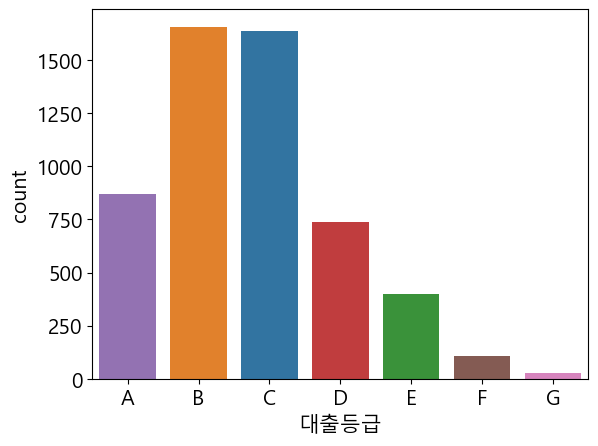

In [ ]:
sns.countplot(x = y_train2, hue = y_train2, order=order_grade)

> data2의 타겟분포를 보면, B가 최빈값입니다. 이 값으로 모두 예측해봅니다.

In [ ]:
from sklearn.metrics import f1_score

model1 = RandomForestClassifier(max_depth=15, n_estimators=150, random_state=42)

features1 = ['대출대비상환원금', 'log원금-이자', 'log남은원금', '대출기간', '상환값추정','주택소유상태_0']

scores = []

kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

for train_idx, val_idx in kf.split(X_train, y_train):

    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    X_tr1, X_tr2 = X_tr[X_tr['상환값추정'] == 0], X_tr[X_tr['상환값추정'] == 1] 
    X_val1, X_val2 = X_val[X_val['상환값추정'] == 0], X_val[X_val['상환값추정'] == 1] 
    y_tr1, y_tr2 = y_tr[X_tr['상환값추정'] == 0], y_tr[X_tr['상환값추정'] == 1] 
    y_val1, y_val2 = y_val[X_val['상환값추정'] == 0], y_val[X_val['상환값추정'] == 1] 
  
    model1.fit(X_tr1[features1],y_tr1)

    pred1 = model1.predict(X_val1[features1])
    pred2 =np.array(['B' for i in range(len(X_val2)) ])

    pred = np.concatenate((pred1,pred2))
    true = np.concatenate((y_val1.values,y_val2.values))

    score = f1_score(true,pred, average='macro')
    display(score)
    # 성능 지표 계산
    scores.append(score)


# 성능 지표의 평균 계산
mean_scores = np.mean(scores)

mean_scores

0.9527171867032999

0.9513112008473004

0.9527173173727869

0.9464478756536411

0.9507983951442571

- cv score:0.9507983951442571


> 결과적으로, 모든 타겟에 대해 학습시킨 모델보다 더 나은 성능을 보입니다.  
> 이로써 학습시키는 타겟의 가짓수를 줄이고, 모델 복잡도를 줄여 예측성능을 향상시키는 시도를 해봅니다.  

## data2(`상환값추정=1`) 모델링 (A,B,C 만을 예측하는 모델)

> 학습데이터의 타겟에 변형을 줍니다.  
> A B C는 그대로, D E F G는 C로 그 값을 대체합니다.  
> 그러면 모델은 A B C에 대해서만 학습을 하며 예측도 A B C만 이루어지게 됩니다.  
> 이는 실제 데이터를 약간 왜곡시키나, data2의 분포의 복잡성을 줄이고 모델이 변형된 데이터에 대해서는 패턴을 잘 파악할 수 있도록합니다.  
> 예측하는 A B C는 빈도수가 높은 데이터이므로, data2에서 D E F G의 예측을 포기하더라도 모델 성능 향상에 도움을 줄 수 있습니다.

> 공개 코드에는 생략하였으나, try1(B) try2(B,C) try3(A,B,C) try4(A,B,C,D)로 시행착오를 겪었습니다.  
> 그 중에 try3가 가장 좋은 성능을 보였습니다.

In [20]:
mapping = {'D':'C', 'E':'C', 'F':'C', 'G':'C'}
y_train2_try3 = y_train2.replace(mapping)

<Axes: xlabel='대출등급', ylabel='count'>

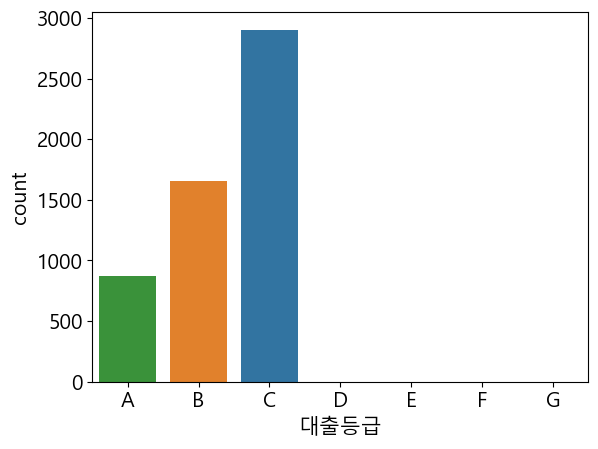

In [23]:
sns.countplot(x = y_train2_try3, hue = y_train2_try3, order=order_grade)

In [ ]:
train2_try3 = pd.concat([X_train2,y_train2_try3], axis =1)

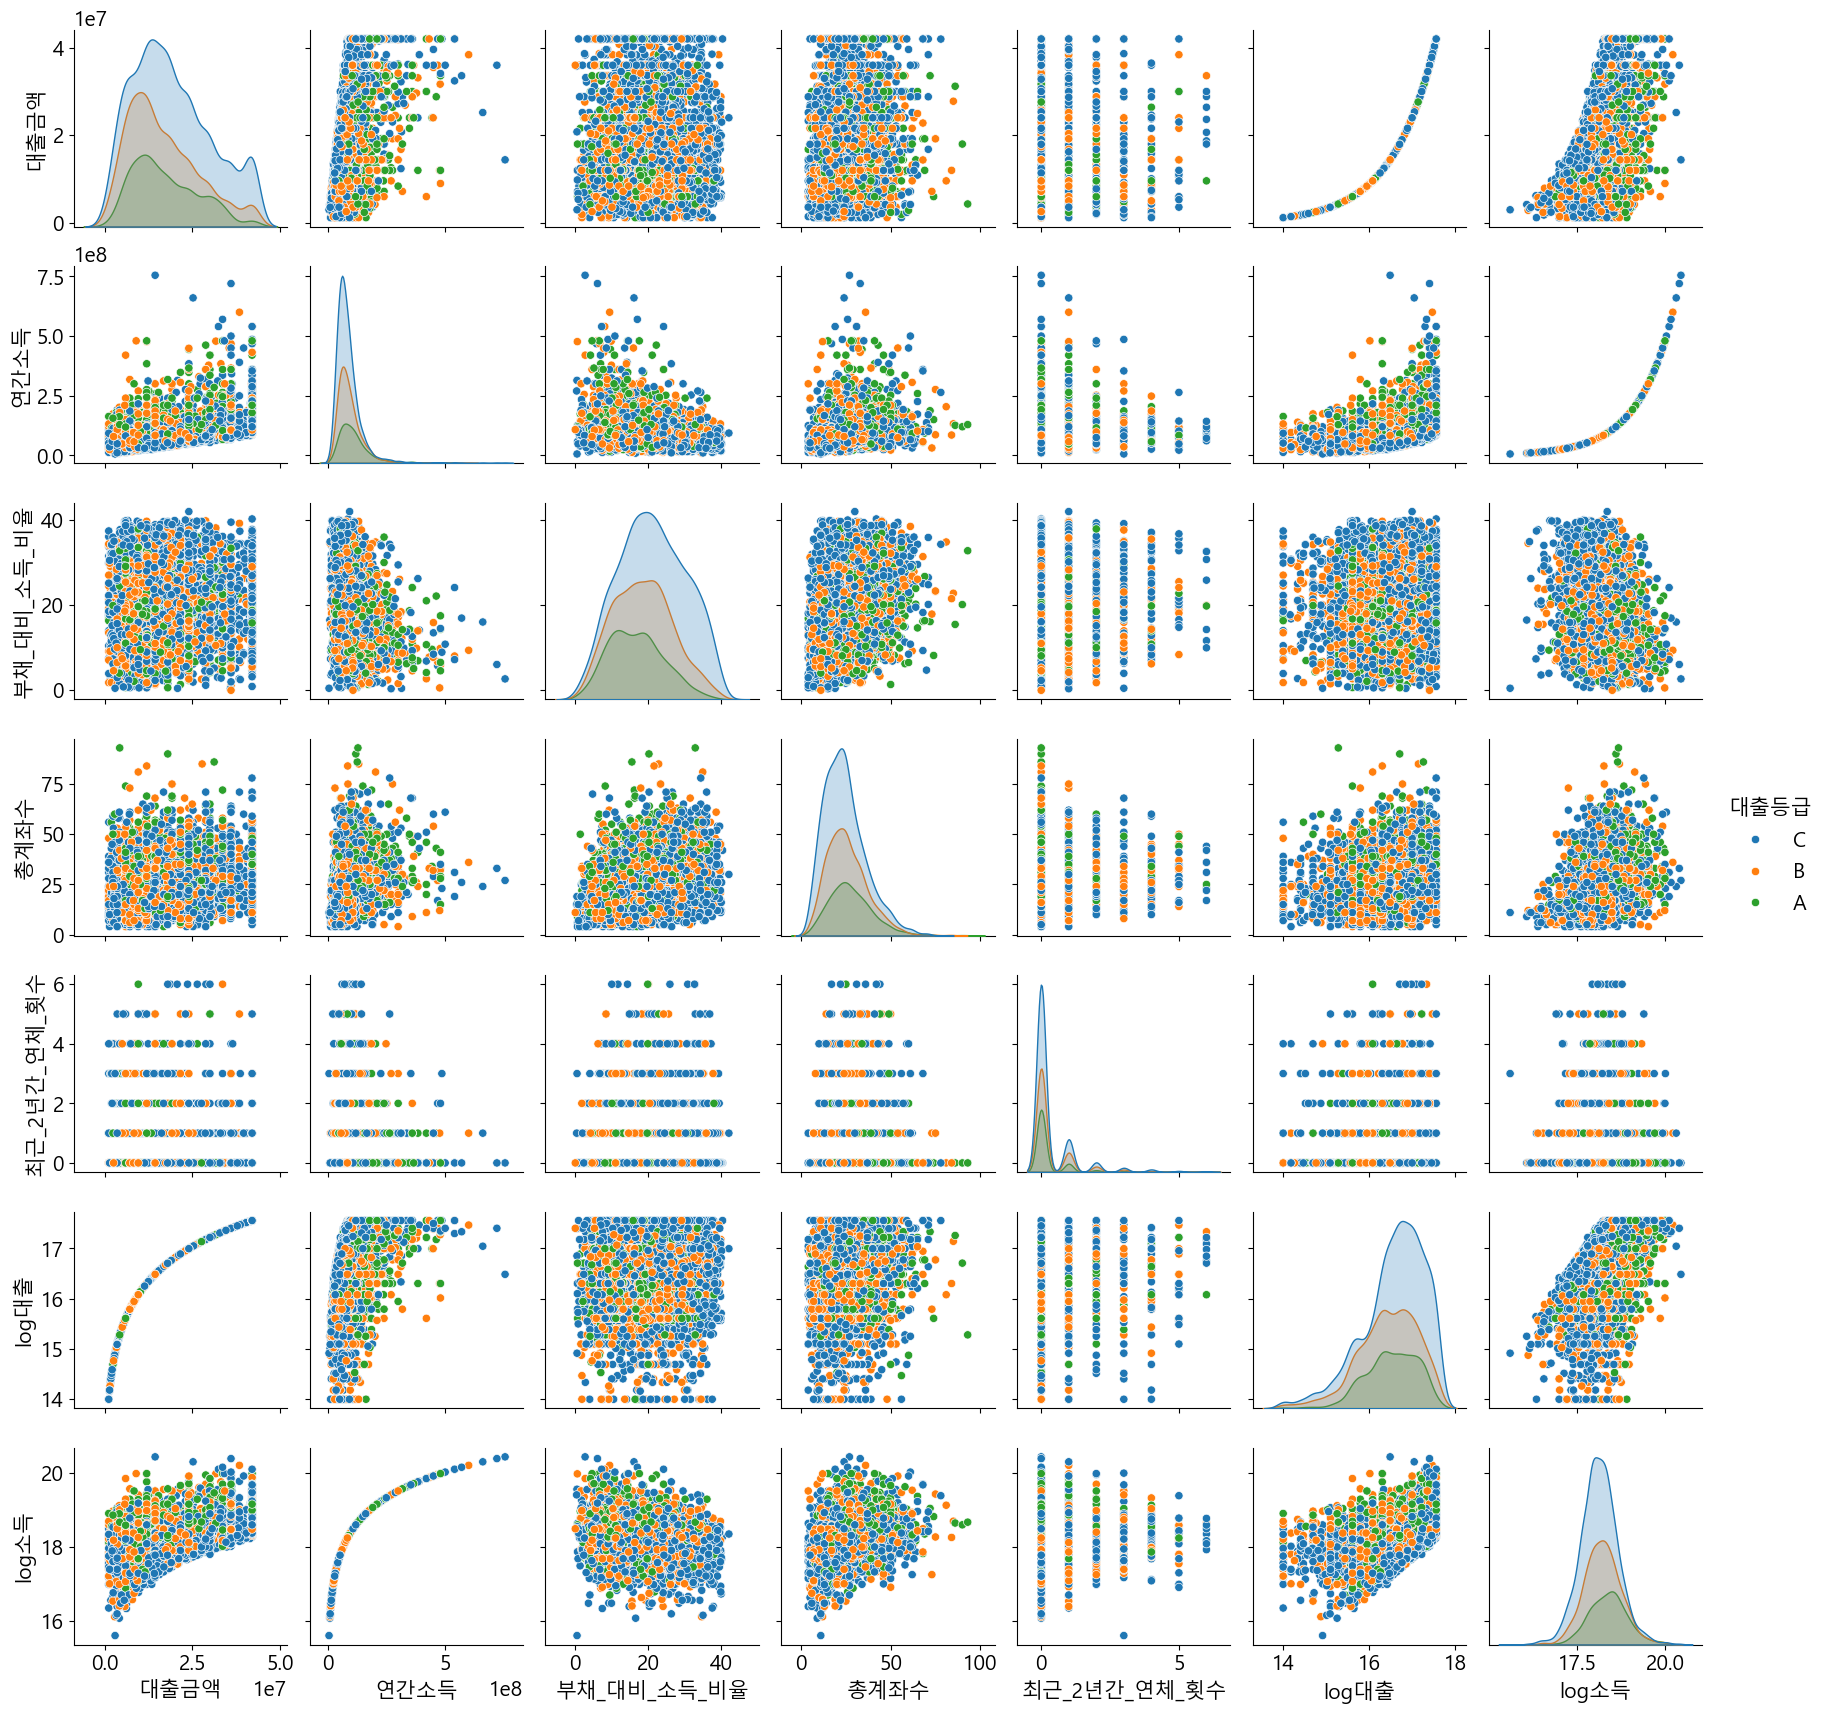

In [ ]:
sns.pairplot(train2_try3[['대출금액','연간소득','부채_대비_소득_비율','총계좌수','최근_2년간_연체_횟수', 'log대출','log소득','대출등급']], hue = target)

### 모델링
앞서 소개한 방식으로 모델링을 그대로 수행하여 모델 선택을 합니다.  
이때 데이터가 대체로 균일하지 않으므로 f1_macro를 기준으로 모델링합니다.  

> 선택된 모델:  
> GradientBoostingClassifier(learning_rate = 0.05, n_estimators=2000, random_state=42)

## 전체 데이터에 대한 교차 검증

In [ ]:
from sklearn.metrics import f1_score

model1 = RandomForestClassifier(max_depth=15, n_estimators=150, random_state=42)
model2 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=200, random_state=42)

features1 = ['대출대비상환원금', 'log원금-이자', 'log남은원금', '대출기간', '상환값추정','주택소유상태_0']
features2 = ['대출금액','연간소득','부채_대비_소득_비율','총계좌수','최근_2년간_연체_횟수','총상환이자','log이자',
 'log소득','대출목적_0','대출목적_1','대출목적_2','대출목적_3','주택소유상태_1','주택소유상태_2','월대출대비소득',
 '최근2년간연체여부','log남은원금','대출대비상환금','대출대비상환원금','대출대비상환이자','log원금-이자','총상환금',
 '소득대비상환금','기간대비상환금','기간대비상환원금']


scores = []
mapping = {'D':'C', 'E':'C', 'F':'C', 'G':'C'}

kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

for train_idx, val_idx in kf.split(X_train, y_train):

    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    X_tr1, X_tr2 = X_tr[X_tr['상환값추정'] == 0], X_tr[X_tr['상환값추정'] == 1] 
    X_val1, X_val2 = X_val[X_val['상환값추정'] == 0], X_val[X_val['상환값추정'] == 1] 
    y_tr1, y_tr2 = y_tr[X_tr['상환값추정'] == 0], y_tr[X_tr['상환값추정'] == 1] 
    y_val1, y_val2 = y_val[X_val['상환값추정'] == 0], y_val[X_val['상환값추정'] == 1] 
    y_tr2 = y_tr2.replace(mapping)
  
    model1.fit(X_tr1[features1],y_tr1)
    model2.fit(X_tr2[features2],y_tr2)

    pred1 = model1.predict(X_val1[features1])
    pred2 = model2.predict(X_val2[features2])

    pred = np.concatenate((pred1,pred2))
    true = np.concatenate((y_val1.values,y_val2.values))

    score = f1_score(true,pred, average='macro')
    display(score)
    # 성능 지표 계산
    scores.append(score)


# 성능 지표의 평균 계산
mean_scores = np.mean(scores)

mean_scores

0.9545194934550143

0.9539110474809703

0.9546901804737246

0.9491360777927185

0.9530641998006069

- cv score: 0.9530641998006069

## Submission1

In [27]:
model1 = RandomForestClassifier(max_depth=15, n_estimators=150, random_state=42)
model2 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=200, random_state=42)
features1 = ['대출대비상환원금', 'log원금-이자', 'log남은원금', '대출기간', '상환값추정', '주택소유상태_0']
features2 = ['대출금액','연간소득','부채_대비_소득_비율','총계좌수','최근_2년간_연체_횟수','총상환이자','log이자',
 'log소득','대출목적_0','대출목적_1','대출목적_2','대출목적_3','주택소유상태_1','주택소유상태_2','월대출대비소득',
 '최근2년간연체여부','log남은원금','대출대비상환금','대출대비상환원금','대출대비상환이자','log원금-이자','총상환금',
 '소득대비상환금','기간대비상환금','기간대비상환원금']
mapping = {'D':'C', 'E':'C', 'F':'C', 'G':'C'}
y_train2_try3 = y_train2.replace(mapping)

model1.fit(X_train1[features1],y_train1)
model2.fit(X_train2[features2],y_train2_try3)
pred1 = model1.predict(test1[features1])
pred2 = model2.predict(test2[features2])

test1['pred'] = pred1
test2['pred'] = pred2

pred =pd.concat([test1,test2]).sort_index()['pred']
submission['대출등급'] = pred

In [28]:
submission.to_csv('submission1.csv',index=False)
submission

ID 대출등급
0      TEST_00000    B
1      TEST_00001    B
2      TEST_00002    A
3      TEST_00003    C
4      TEST_00004    C
...           ...  ...
64192  TEST_64192    D
64193  TEST_64193    D
64194  TEST_64194    D
64195  TEST_64195    C
64196  TEST_64196    A

[64197 rows x 2 columns]

# **model2**
model1에서 data2에 대해 보팅알고리즘을 적용해, 평균적 예측성능은 유지하면서 예측의 변동성을 줄인 모델

> model3의 검증 score를 보면, 학습데이터마다 성능이 크게 다릅니다.  
> 이는 실제 데이터 예측에서 좋지 못한 성능을 보일 수도 있습니다.

## models for voting
model3에서 data2에 대한 모델 선택을 할때, 얻은 다른 모델들의 성능을 향상시키고 보팅 알고리즘에 같이 사용합니다.  

- 선택된 모델들:  
1. RandomForestClassifier(max_depth=9, n_estimators=300, random_state=42)  
1. LGBMClassifier(max_depth=3, num_leaves=25, random_state=42)
2. ExtraTreesClassifier(max_depth=15, random_state=42)
3. KNeighborsClassifier(n_neighbors=20)
4. GradientBoostingClassifier(learning_rate=0.05, n_estimators=200,random_state=42)

## soft voting적용

### 각 교차검증 과정에서 각 모델들의 예측확률 계산.

In [ ]:
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

model1 = RandomForestClassifier(max_depth=15, n_estimators=150, random_state=42)
model_RF = RandomForestClassifier(max_depth=9, n_estimators=300, random_state=42)
model_LGBM = LGBMClassifier(max_depth=3, num_leaves=25, random_state=42)
model_ET = ExtraTreesClassifier(max_depth=15, random_state=42)
model_KNN  = KNeighborsClassifier(n_neighbors=20)
model_GBC = GradientBoostingClassifier(learning_rate=0.05, n_estimators=200,random_state=42)

features1 = ['대출대비상환원금', 'log원금-이자', 'log남은원금', '대출기간', '상환값추정', '주택소유상태_0']
features_RF = ['log이자', '대출기간', '대출대비상환원금', 'log원금-이자', '이자vs원금', '월대출', '월대출대비소득',
 'log소득', '부채_대비_소득_비율','총상환금','log남은원금','총계좌수','총상환원금','소득대비상환금',
 '최근2년간연체여부','대출금액','연간소득','기간대비상환금','기간대비상환원금','기간대비상환이자','대출대비상환금',
 '대출대비상환이자','log원금','log대출']
features_LGBM = ['log이자','대출대비상환원금','log원금-이자','월대출','월대출대비소득','총상환금',
 '총상환원금','소득대비상환금','최근2년간연체여부','기간대비상환원금','대출대비상환금','대출대비상환이자','log대출']
features_ET = ['log이자','대출기간','대출대비상환원금','log원금-이자','월대출대비소득','log남은원금',
 '총상환원금','소득대비상환금','최근2년간연체여부','기간대비상환원금','기간대비상환이자','대출대비상환금','대출대비상환이자','log원금','log대출']
features_KNN = ['log이자','대출기간','대출대비상환원금','log원금-이자', '이자vs원금','월대출','월대출대비소득',
            '총상환금', 'log남은원금','상환값추정','총상환원금', '소득대비상환금','최근2년간연체여부',
            '기간대비상환금','기간대비상환이자','대출대비상환금','log원금','log대출']
features_GBC = ['대출금액','연간소득','부채_대비_소득_비율','총계좌수','최근_2년간_연체_횟수','총상환이자','log이자',
 'log소득','대출목적_0','대출목적_1','대출목적_2','대출목적_3','주택소유상태_1','주택소유상태_2','월대출대비소득',
 '최근2년간연체여부','log남은원금','대출대비상환금','대출대비상환원금','대출대비상환이자','log원금-이자','총상환금',
 '소득대비상환금','기간대비상환금','기간대비상환원금']
RF = []
LGBM = []
ET= []
KNN = []
GBC = []
prediction1 = []
true = []
mapping = {'D':'C', 'E':'C', 'F':'C', 'G':'C'}

kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

for train_idx, val_idx in kf.split(X_train, y_train):

    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    X_tr1, X_tr2 = X_tr[X_tr['상환값추정'] == 0], X_tr[X_tr['상환값추정'] == 1] 
    X_val1, X_val2 = X_val[X_val['상환값추정'] == 0], X_val[X_val['상환값추정'] == 1] 
    y_tr1, y_tr2 = y_tr[X_tr['상환값추정'] == 0], y_tr[X_tr['상환값추정'] == 1] 
    y_val1, y_val2 = y_val[X_val['상환값추정'] == 0], y_val[X_val['상환값추정'] == 1] 
    y_tr2 = y_tr2.replace(mapping)
    X_tr2_scaled = pd.DataFrame(scaler.fit_transform(X_tr2), columns = X_tr2.columns)
    X_val2_scaled = pd.DataFrame(scaler.transform(X_val2), columns = X_tr2.columns)
  
    model1.fit(X_tr1[features1],y_tr1)
    model_RF.fit(X_tr2[features_RF],y_tr2)
    model_LGBM.fit(X_tr2[features_LGBM],y_tr2)
    model_ET.fit(X_tr2[features_ET],y_tr2)
    model_KNN.fit(X_tr2_scaled[features_KNN],y_tr2)
    model_GBC.fit(X_tr2[features_GBC],y_tr2)

    pred1 = model1.predict(X_val1[features1])
    soft_RF = model_RF.predict_proba(X_val2[features_RF])
    soft_LGBM = model_LGBM.predict_proba(X_val2[features_LGBM])
    soft_ET = model_ET.predict_proba(X_val2[features_ET])
    soft_KNN = model_KNN.predict_proba(X_val2_scaled[features_KNN])
    soft_GBC = model_GBC.predict_proba(X_val2[features_GBC])

    prediction1.append(pred1)
    RF.append(soft_RF)
    LGBM.append(soft_LGBM)
    ET.append(soft_ET)
    KNN.append(soft_KNN)
    GBC.append(soft_GBC)
    true.append(np.concatenate((y_val1.values,y_val2.values)))

### weight tuning 및 검증 점수

> 원래 5개 모델에 대해서 해야하는데, 저는 시간 관계상 세 개 모델에 대해서만 했습니다.

In [34]:
prediction2 = {}
prediction = {}
scores = {}
weight = [0,6,7,8,9,10,11,12,13,14,15]
for i in weight:
    for j in weight:
        for k in [10,11,12,13,14,15]:
                    score = []
                    for n in range(4):
                        soft_max = i*RF[n] + j*LGBM[n] + k*GBC[n]
                        prediction2[n] = pd.DataFrame(soft_max, columns=['A','B','C']).idxmax(axis = 1)
                        prediction[n] = np.concatenate((prediction1[n],prediction2[n].values))
                        score.append(f1_score(true[n],prediction[n], average='macro'))
                    scores[f'({i},{j},{k})'] = np.mean(score)


In [35]:
best = max(scores, key=scores.get)
cv_score = scores[best]

In [36]:
sorted(scores.items(), key=lambda x: x[1], reverse=True)[:10]

[('(0,0,10)', 0.9530641998006069),
 ('(0,0,11)', 0.9530641998006069),
 ('(0,0,12)', 0.9530641998006069),
 ('(0,0,13)', 0.9530641998006069),
 ('(0,0,14)', 0.9530641998006069),
 ('(0,0,15)', 0.9530641998006069),
 ('(0,6,13)', 0.9530494541854713),
 ('(0,7,13)', 0.9530376511326755),
 ('(0,8,15)', 0.9530376511326755),
 ('(0,7,15)', 0.9530375617427365)]

- cv score : 0.9530494541854713

> key (0,6,13)을 보면, 처음으로 GBC 모델이 아닌 다른 모델에 0이 아닌 가중치가 생긴 모델입니다.  
> GBC 단일모델에 비해 검증 점수의 차이가 거의 없으며, 검증이 아닌 새로운 데이터의 추측에 관점에서  
> 보팅 알고리즘이 더 안정적인 결과를 가져다 줄 수 있습니다. 따라서 이 모델로 두번째 submission을 생성합니다.

## Submission2

In [ ]:
from lightgbm import LGBMClassifier

model1 = RandomForestClassifier(max_depth=15, n_estimators=150, random_state=42)
model_RF = RandomForestClassifier(max_depth=9, n_estimators=300, random_state=42)
model_LGBM = LGBMClassifier(max_depth=3, num_leaves=25, random_state=42)
model_GBC = GradientBoostingClassifier(learning_rate=0.05, n_estimators=200,random_state=42)

features1 = ['대출대비상환원금', 'log원금-이자', 'log남은원금', '대출기간', '상환값추정', '주택소유상태_0']
features_RF = ['log이자', '대출기간', '대출대비상환원금', 'log원금-이자', '이자vs원금', '월대출', '월대출대비소득',
 'log소득', '부채_대비_소득_비율','총상환금','log남은원금','총계좌수','총상환원금','소득대비상환금',
 '최근2년간연체여부','대출금액','연간소득','기간대비상환금','기간대비상환원금','기간대비상환이자','대출대비상환금',
 '대출대비상환이자','log원금','log대출']
features_LGBM = ['log이자','대출대비상환원금','log원금-이자','월대출','월대출대비소득','총상환금',
 '총상환원금','소득대비상환금','최근2년간연체여부','기간대비상환원금','대출대비상환금','대출대비상환이자','log대출']
features_GBC = ['대출금액','연간소득','부채_대비_소득_비율','총계좌수','최근_2년간_연체_횟수','총상환이자','log이자',
 'log소득','대출목적_0','대출목적_1','대출목적_2','대출목적_3','주택소유상태_1','주택소유상태_2','월대출대비소득',
 '최근2년간연체여부','log남은원금','대출대비상환금','대출대비상환원금','대출대비상환이자','log원금-이자','총상환금',
 '소득대비상환금','기간대비상환금','기간대비상환원금']

mapping = {'D':'C', 'E':'C', 'F':'C', 'G':'C'}
y_train2_try3 = y_train2.replace(mapping)

model1.fit(X_train1[features1],y_train1)
model_LGBM.fit(X_train2[features_LGBM],y_train2_try3)
model_RF.fit(X_train2[features_RF],y_train2_try3)
model_GBC.fit(X_train2[features_GBC],y_train2_try3)

pred1 = model1.predict(test1[features1])
soft_LGBM = model_LGBM.predict_proba(test2[features_LGBM])
soft_RF = model_RF.predict_proba(test2[features_RF])
soft_GBC = model_GBC.predict_proba(test2[features_GBC])

soft_max = 6*soft_LGBM + 13*soft_GBC 
soft_max = pd.DataFrame(soft_max, columns=['A','B','C'])

pred2 = soft_max.idxmax(axis = 1)

test1['pred'] = pred1
test2['pred'] = pred2.values

pred =pd.concat([test1,test2]).sort_index()['pred']
submission['대출등급'] = pred

In [30]:
submission.to_csv('submission2.csv',index=False)
submission

ID 대출등급
0      TEST_00000    B
1      TEST_00001    B
2      TEST_00002    A
3      TEST_00003    C
4      TEST_00004    C
...           ...  ...
64192  TEST_64192    D
64193  TEST_64193    D
64194  TEST_64194    D
64195  TEST_64195    C
64196  TEST_64196    A

[64197 rows x 2 columns]